In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [1]:
import json
import re
from functools import partial
from io import StringIO
from itertools import combinations
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from QligFEP.analyze_FEP import FepReader
from scipy import stats
from scipy.stats import kendalltau
from sklearn.metrics import mean_absolute_error

In [158]:
from typing import Union
from rdkit import Chem
from openff.toolkit import Molecule
from QligFEP.chemIO import MoleculeIO
from QligFEP.CLI.utils import get_avail_restraint_methods
from QligFEP.restraints.restraint_setter import RestraintSetter
from pyfonts import load_google_font

tick_font = load_google_font("Montserrat", weight=500)
label_font = load_google_font("Montserrat", weight=500, italic=True)
title_font = load_google_font("Montserrat", weight=500)


def set_font_properties(ax, tick_font=tick_font, label_font=label_font, title_font=title_font):
    ax.set_xlabel(ax.get_xlabel(), fontproperties=label_font, size=12)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=label_font, size=12)
    ax.set_title(ax.get_title(), fontproperties=title_font, size=14)
    for label in ax.get_xticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    legend = ax.get_legend()
    if legend:
        # Update the font properties of the legend texts
        for text in legend.get_texts():
            text.set_fontproperties(label_font)
        # Optionally, update the font of the legend title if it exists
        if legend.get_title():
            legend.get_title().set_fontproperties(title_font)


def calculate_restraint_similarity(
    ligand1: Union[Molecule, Chem.Mol, str, Path],
    ligand2: Union[Molecule, Chem.Mol, str, Path],
    restraint_method: str = "hybridization_p",
) -> dict[int, int]:
    """Apply the restraints according to the specified method and calculate several similarity
    scores between them.

    Args:
        ligand1: First ligand (RDKit Mol or custom Molecule object).
        ligand2: Second ligand (RDKit Mol or custom Molecule object).
        restraint_method: Chosen method for setting the ligand restraints. Defaults to "hybridization_p".

    Returns: # TODO
        The similarity score between the two ligands, calculated as the squared number of restrained atoms
        divided by the product of the number of atoms in each ligand.
    """
    ligand1 = RestraintSetter.input_to_small_molecule_component(ligand1)
    ligand2 = RestraintSetter.input_to_small_molecule_component(ligand2)

    # Handle cases where a custom kartograf threshold is provided
    kartograf_thresh = 0.95
    if len(restraint_method.split("_")) == 3:
        kartograf_thresh = float(restraint_method.split("_")[2])
        restraint_method = "_".join(restraint_method.split("_")[:2])
        pass
    elif len(restraint_method.split("_")) > 3:
        raise ValueError(
            f"restraint_method should be of the form `method_permissiveness_krtgrfThresh`, got {restraint_method}"
        )

    # Check if the passed restraint method is available
    if restraint_method not in get_avail_restraint_methods():
        raise ValueError(
            f"restraint_method should be one of {get_avail_restraint_methods()}, got {restraint_method}"
        )
    elif restraint_method == "overlap":
        raise ValueError("Overlap method is not supported by this method yet, use `kartograf` instead.")
    rsetter = RestraintSetter(ligand1, ligand2, kartograf_thresh)

    # Set the restraints according to the chosen method
    if restraint_method == "kartograf":
        restraint_dict = rsetter.set_restraints(
            kartograf_native=True,  # other arguments ignored
        )
    else:
        atom_compare_method, permissiveness_lvl = restraint_method.split("_")
        if permissiveness_lvl == "p":
            # in this case, ignore_surround_atom_type is not needed
            params = {"strict_surround": False}
        elif permissiveness_lvl == "ls":
            params = {"strict_surround": True, "ignore_surround_atom_type": True}
        elif permissiveness_lvl == "strict":
            params = {"strict_surround": True, "ignore_surround_atom_type": False}
        restraint_dict = rsetter.set_restraints(atom_compare_method=atom_compare_method, **params)
        # logger.debug(f"Restraints set using {restraint_method} method. Parameters: {params}")

    # Calculate some metrics on the differences between the ligands: can we estimate the error?
    n_restrained = len(restraint_dict.keys())
    natoms_lig1 = ligand1.to_rdkit().GetNumHeavyAtoms()
    natoms_lig2 = ligand2.to_rdkit().GetNumHeavyAtoms()
    similarity = n_restrained**2 / (natoms_lig1 * natoms_lig2)
    atom_n_diff = abs(natoms_lig1 - natoms_lig2)
    unrestrained_bigger_mol = max(natoms_lig1, natoms_lig2) - n_restrained

    nRingsA = len(rsetter.atom_mapper.identify_and_enumerate_rings(ligand1.to_rdkit()))
    nRingsB = len(rsetter.atom_mapper.identify_and_enumerate_rings(ligand2.to_rdkit()))
    diff_rings = abs(nRingsA - nRingsB)
    return similarity, atom_n_diff, unrestrained_bigger_mol, diff_rings

In [159]:
all_dataframes = []

# JACS

## bace

2025-08-18 16:35:22 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.31_{0.15}^{0.48}$ (Kendall's $\tau$) RMSE = $1.69_{1.44}^{1.93}  \frac{kcal}{mol}$ MUE = $1.37_{1.11}^{1.65}  \frac{kcal}{mol}$


Crashes:  0


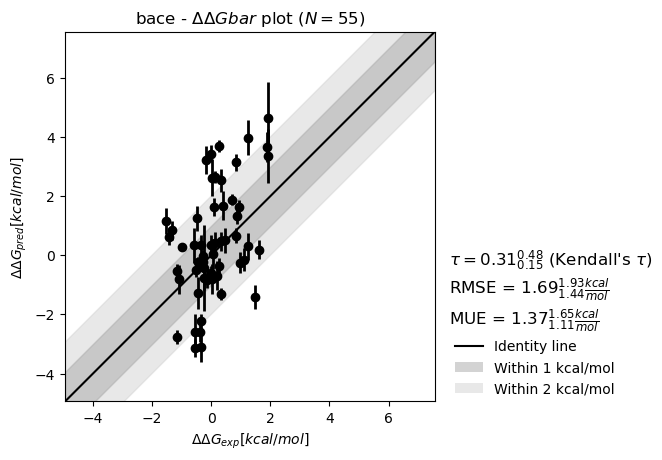

In [4]:
json_results = json.loads(Path("results/bace/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="bace",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [5]:
fep_names = {}

chemio = MoleculeIO("perturbations/bace/ligands.sdf")
network_dict = json.loads(Path("perturbations/bace/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## cdk2

2025-08-18 16:35:27 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.30_{-0.05}^{0.59}$ (Kendall's $\tau$) RMSE = $1.21_{0.88}^{1.54}  \frac{kcal}{mol}$ MUE = $1.02_{0.77}^{1.32}  \frac{kcal}{mol}$


Crashes:  0


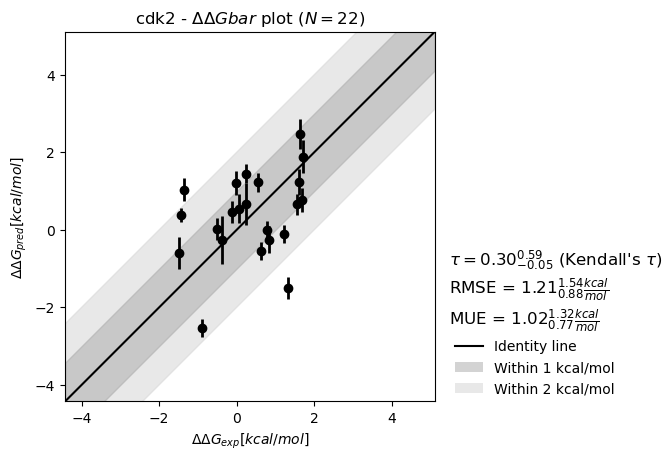

In [6]:
json_results = json.loads(Path("results/cdk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [7]:
fep_names = {}

chemio = MoleculeIO("perturbations/cdk2/ligands.sdf")
network_dict = json.loads(Path("perturbations/cdk2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 30. Reindexed.
2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 28. Reindexed.
2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oiy. Reindexed.
2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oi9. Reindexed.
2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 32. Reindexed.
2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oiu. Reindexed.
2025-08-18 16:35:27 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2

## jnk1

2025-08-18 16:35:31 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.35_{0.05}^{0.62}$ (Kendall's $\tau$) RMSE = $1.45_{1.06}^{1.82}  \frac{kcal}{mol}$ MUE = $1.17_{0.86}^{1.5}  \frac{kcal}{mol}$


Crashes:  0


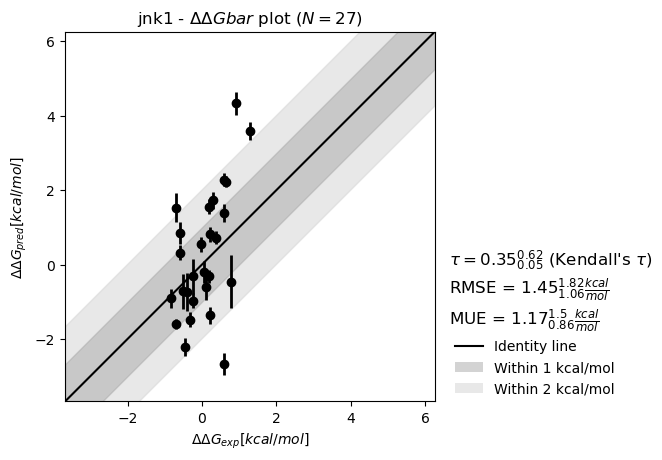

In [8]:
json_results = json.loads(Path("results/jnk1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="jnk1",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [9]:
fep_names = {}

chemio = MoleculeIO("perturbations/jnk1/ligands.sdf")
network_dict = json.loads(Path("perturbations/jnk1/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18626-1. Reindexed.
2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18628-1_flip. Reindexed.
2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18629-1. Reindexed.
2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18636-1. Reindexed.
2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18638-1. Reindexed.
2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18659-1. Reindexed.
2025-08-18 16:35:31 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of

## mcl1

2025-08-18 16:35:35 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.19_{0.03}^{0.36}$ (Kendall's $\tau$) RMSE = $2.04_{1.56}^{2.59}  \frac{kcal}{mol}$ MUE = $1.55_{1.22}^{1.9}  \frac{kcal}{mol}$


Crashes:  0


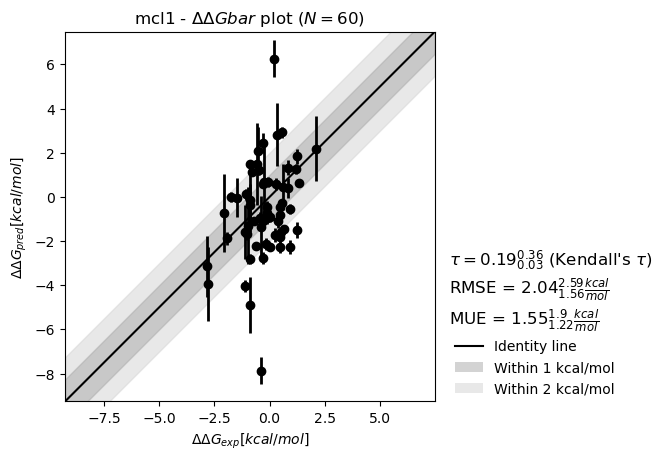

In [10]:
json_results = json.loads(Path("results/mcl1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="mcl1",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [11]:
fep_names = {}

chemio = MoleculeIO("perturbations/mcl1/ligands.sdf")
network_dict = json.loads(Path("perturbations/mcl1/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 23. Reindexed.
2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 26. Reindexed.
2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 27. Reindexed.
2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 28. Reindexed.
2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 29. Reindexed.
2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 30_flip. Reindexed.
2025-08-18 16:35:36 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 31

## p38

2025-08-18 16:35:40 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:535 - Dropping FEPs with nan values: ['FEP_2k_2u']
2025-08-18 16:35:42 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.58_{0.44}^{0.71}$ (Kendall's $\tau$) RMSE = $1.50_{1.25}^{1.74}  \frac{kcal}{mol}$ MUE = $1.22_{0.99}^{1.47}  \frac{kcal}{mol}$


Crashes:  1


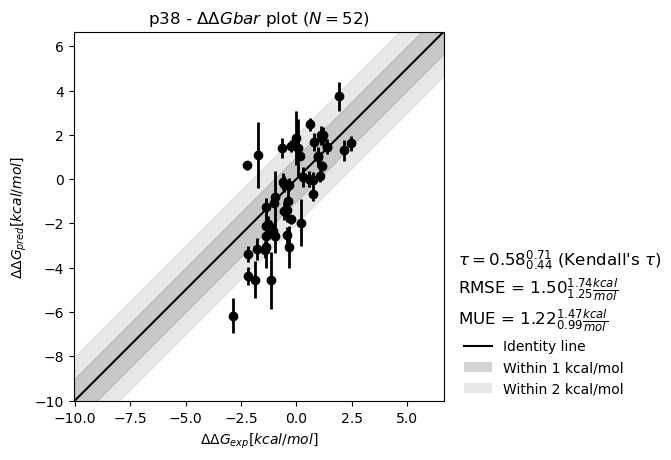

In [12]:
json_results = json.loads(Path("results/p38/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="p38",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [13]:
fep_names = {}

chemio = MoleculeIO("perturbations/p38/ligands.sdf")
network_dict = json.loads(Path("perturbations/p38/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:35:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2gg. Reindexed.
2025-08-18 16:35:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2q. Reindexed.
2025-08-18 16:35:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2t. Reindexed.
2025-08-18 16:35:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2l. Reindexed.
2025-08-18 16:35:44 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2ee. Reindexed.
2025-08-18 16:35:44 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2aa. Reindexed.
2025-08-18 16:35:44 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2o. 

## ptp1b

2025-08-18 16:35:49 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.41_{0.22}^{0.58}$ (Kendall's $\tau$) RMSE = $2.49_{1.71}^{3.23}  \frac{kcal}{mol}$ MUE = $1.86_{1.31}^{2.49}  \frac{kcal}{mol}$


Crashes:  0


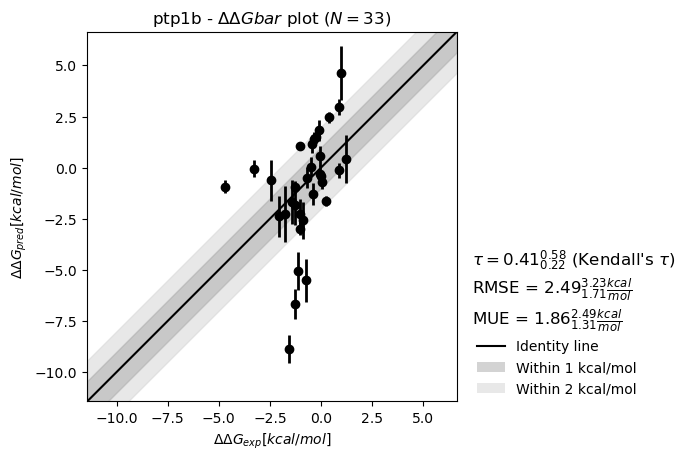

In [14]:
json_results = json.loads(Path("results/ptp1b/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

### 2x Sampling

For `ptp1b`, we noticed outliers with very low energies for groups involving large perturbations. Therefore, we decided to run the same perturbation but with doubled sampling for each lambda step. The results we got are below:

2025-08-18 16:35:51 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.39_{0.19}^{0.56}$ (Kendall's $\tau$) RMSE = $1.89_{1.45}^{2.3}  \frac{kcal}{mol}$ MUE = $1.55_{1.21}^{1.96}  \frac{kcal}{mol}$


Crashes:  0


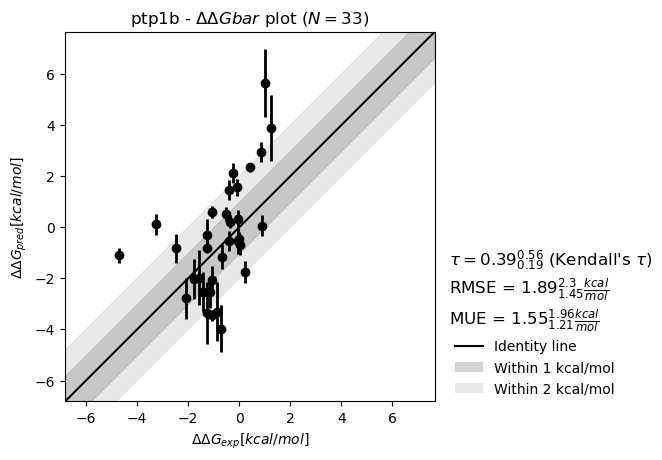

In [15]:
json_results = json.loads(Path("results/ptp1b2xSampled/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [16]:
fep_names = {}

chemio = MoleculeIO("perturbations/p38/ligands.sdf")
network_dict = json.loads(Path("perturbations/p38/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2gg. Reindexed.
2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2q. Reindexed.
2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2t. Reindexed.
2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2l. Reindexed.
2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2ee. Reindexed.
2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2aa. Reindexed.
2025-08-18 16:35:52 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2o. 

## thrombin

2025-08-18 16:35:56 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.43_{-0.08}^{0.84}$ (Kendall's $\tau$) RMSE = $1.17_{0.88}^{1.47}  \frac{kcal}{mol}$ MUE = $1.04_{0.77}^{1.35}  \frac{kcal}{mol}$


Crashes:  0


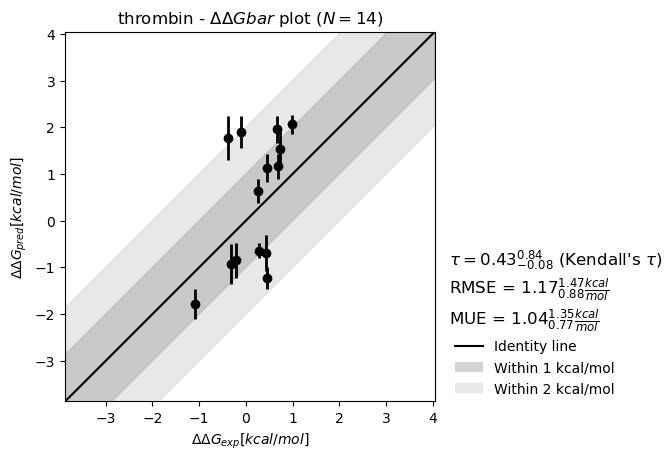

In [17]:
json_results = json.loads(Path("results/thrombin/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="thrombin",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [18]:
fep_names = {}

chemio = MoleculeIO("perturbations/thrombin/ligands.sdf")
network_dict = json.loads(Path("perturbations/thrombin/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6a. Reindexed.
2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 3a. Reindexed.
2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1d. Reindexed.
2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6e. Reindexed.
2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6b. Reindexed.
2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1b. Reindexed.
2025-08-18 16:35:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1a. Rei

## tyk2

2025-08-18 16:36:00 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.32_{-0.03}^{0.62}$ (Kendall's $\tau$) RMSE = $1.21_{0.88}^{1.53}  \frac{kcal}{mol}$ MUE = $0.97_{0.66}^{1.28}  \frac{kcal}{mol}$


Crashes:  0


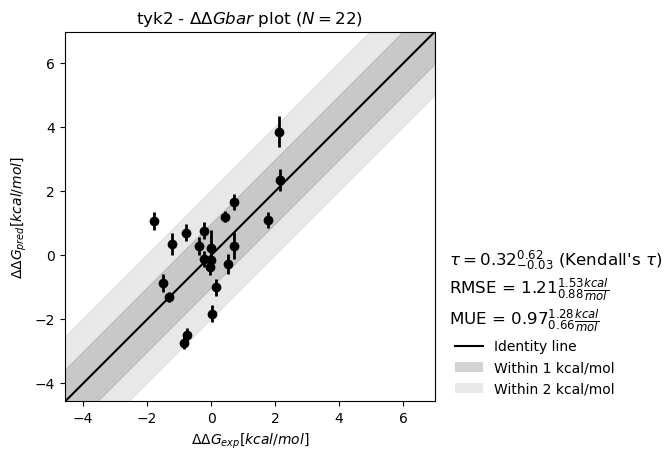

In [19]:
json_results = json.loads(Path("results/tyk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tyk2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [20]:
fep_names = {}

chemio = MoleculeIO("perturbations/tyk2/ligands.sdf")
network_dict = json.loads(Path("perturbations/tyk2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule jmc_23. Reindexed.
2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_47. Reindexed.
2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_49. Reindexed.
2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_45. Reindexed.
2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_44. Reindexed.
2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_43. Reindexed.
2025-08-18 16:36:00 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom l

# Merck

## cdk8

2025-08-18 16:36:03 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.14_{-0.08}^{0.34}$ (Kendall's $\tau$) RMSE = $3.41_{2.69}^{4.02}  \frac{kcal}{mol}$ MUE = $2.72_{2.16}^{3.29}  \frac{kcal}{mol}$


Crashes:  0


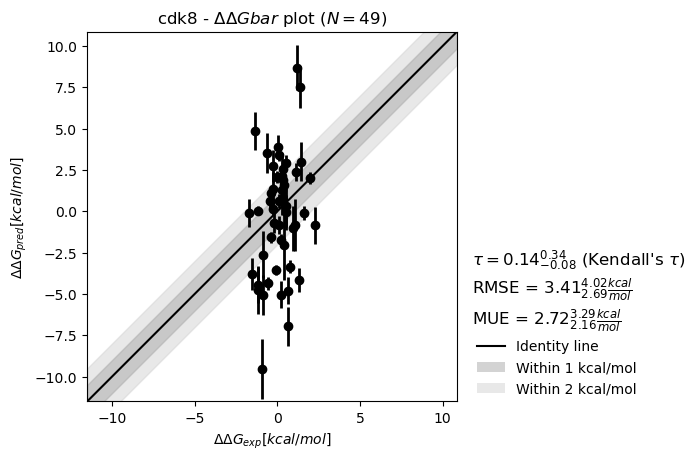

In [21]:
json_results = json.loads(Path("results/cdk8/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

### Manual Mapping

For `cdk8`, we noticed a lot of the perturbations present in the automated mapping were difficult to accomplish. In this ligand set, two R-groups get perturbed at once, making it more prone for endpoint catastrophes. We decided to manually map the perturbations to avoid this. The results we got are below:

2025-08-18 16:36:06 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.24_{0.05}^{0.43}$ (Kendall's $\tau$) RMSE = $2.95_{2.38}^{3.47}  \frac{kcal}{mol}$ MUE = $2.35_{1.92}^{2.84}  \frac{kcal}{mol}$


Crashes:  0


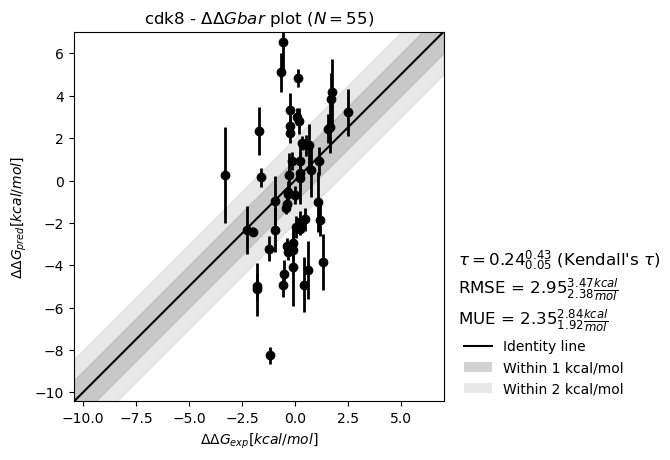

In [22]:
json_results = json.loads(Path("results/cdk8ManualMapping/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [23]:
fep_names = {}

chemio = MoleculeIO("perturbations/cdk8/ligands.sdf")
network_dict = json.loads(Path("perturbations/cdk8/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## cmet

2025-08-18 16:36:12 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.44_{0.25}^{0.64}$ (Kendall's $\tau$) RMSE = $2.46_{1.79}^{3.14}  \frac{kcal}{mol}$ MUE = $1.93_{1.43}^{2.46}  \frac{kcal}{mol}$


Crashes:  0


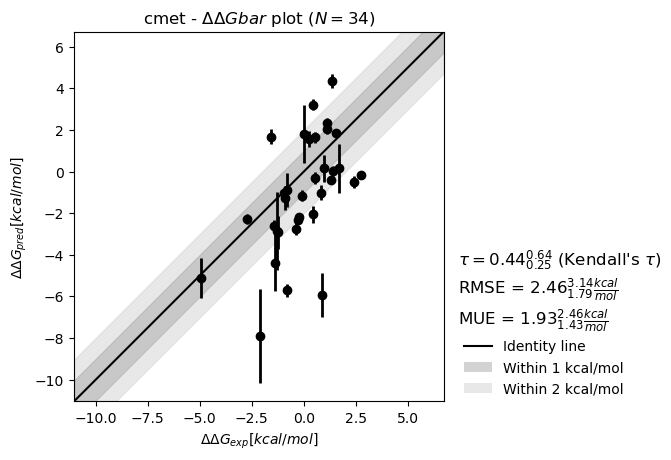

In [24]:
json_results = json.loads(Path("results/cmet/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cmet",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [25]:
fep_names = {}

chemio = MoleculeIO("perturbations/cmet/ligands.sdf")
network_dict = json.loads(Path("perturbations/cmet/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## eg5

2025-08-18 16:36:17 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.31_{0.07}^{0.51}$ (Kendall's $\tau$) RMSE = $1.95_{1.56}^{2.33}  \frac{kcal}{mol}$ MUE = $1.61_{1.28}^{1.97}  \frac{kcal}{mol}$


Crashes:  0


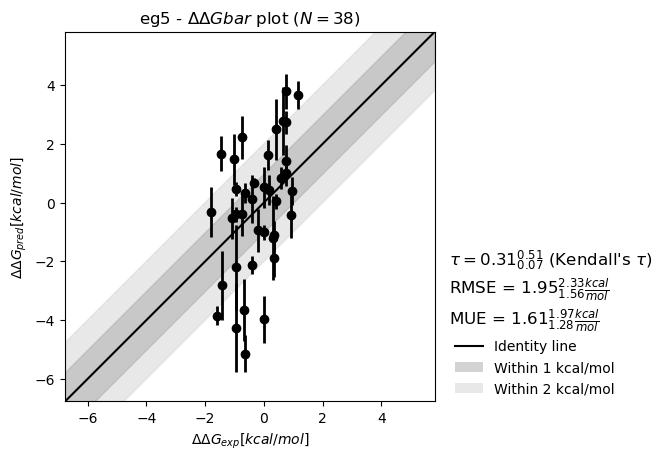

In [26]:
json_results = json.loads(Path("results/eg5/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="eg5",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [27]:
fep_names = {}

chemio = MoleculeIO("perturbations/eg5/ligands.sdf")
network_dict = json.loads(Path("perturbations/eg5/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## hif2a

2025-08-18 16:36:23 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.31_{0.13}^{0.47}$ (Kendall's $\tau$) RMSE = $2.07_{1.74}^{2.39}  \frac{kcal}{mol}$ MUE = $1.71_{1.41}^{2.04}  \frac{kcal}{mol}$


Crashes:  0


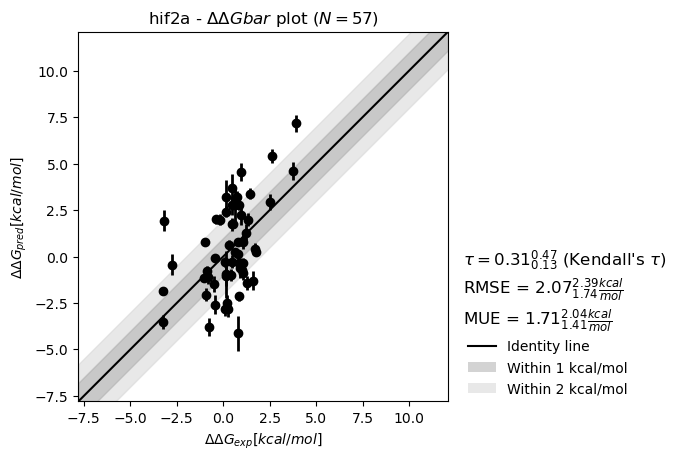

In [28]:
json_results = json.loads(Path("results/hif2a/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="hif2a",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [29]:
fep_names = {}

chemio = MoleculeIO("perturbations/hif2a/ligands.sdf")
network_dict = json.loads(Path("perturbations/hif2a/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## shp2

2025-08-18 16:36:29 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.51_{0.32}^{0.67}$ (Kendall's $\tau$) RMSE = $2.45_{2.03}^{2.82}  \frac{kcal}{mol}$ MUE = $2.07_{1.63}^{2.48}  \frac{kcal}{mol}$


Crashes:  0


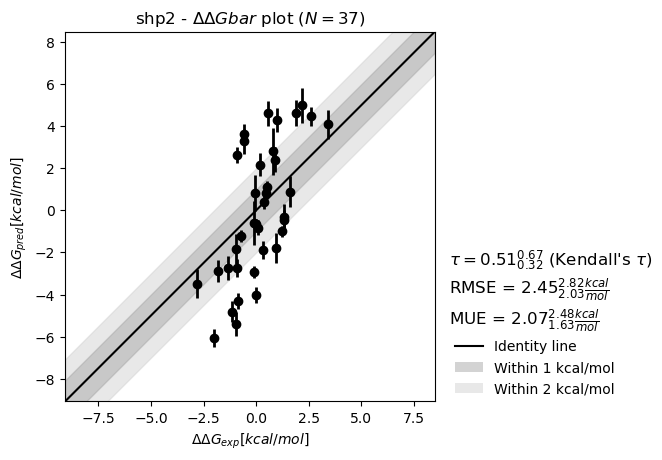

In [30]:
json_results = json.loads(Path("results/shp2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="shp2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [31]:
fep_names = {}

chemio = MoleculeIO("perturbations/shp2/ligands.sdf")
network_dict = json.loads(Path("perturbations/shp2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p_1.2"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:36:29 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-22. Reindexed.
2025-08-18 16:36:29 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 11. Reindexed.
2025-08-18 16:36:30 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-6. Reindexed.
2025-08-18 16:36:30 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-9. Reindexed.
2025-08-18 16:36:30 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-8. Reindexed.
2025-08-18 16:36:30 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 7. Reindexed.
2025-08-18 16:36:30 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the at

## syk

2025-08-18 16:36:34 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.29_{0.1}^{0.46}$ (Kendall's $\tau$) RMSE = $1.29_{1.02}^{1.56}  \frac{kcal}{mol}$ MUE = $1.03_{0.84}^{1.22}  \frac{kcal}{mol}$


Crashes:  0


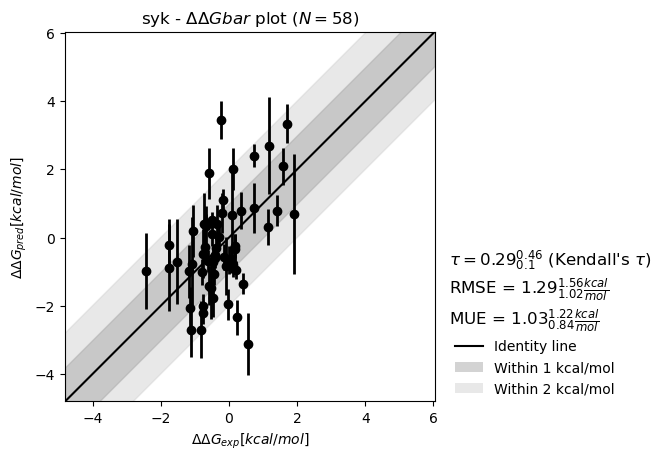

In [32]:
json_results = json.loads(Path("results/syk/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="syk",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [33]:
fep_names = {}

chemio = MoleculeIO("perturbations/syk/ligands.sdf")
network_dict = json.loads(Path("perturbations/syk/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## pfkfb3

2025-08-18 16:36:42 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.30_{0.1}^{0.49}$ (Kendall's $\tau$) RMSE = $1.70_{1.32}^{2.08}  \frac{kcal}{mol}$ MUE = $1.37_{1.11}^{1.67}  \frac{kcal}{mol}$


Crashes:  0


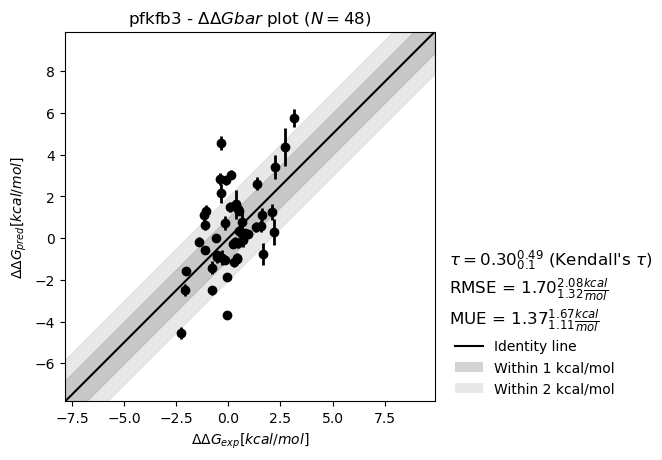

In [34]:
json_results = json.loads(Path("results/pfkfb3/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="pfkfb3",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [35]:
fep_names = {}

chemio = MoleculeIO("perturbations/pfkfb3/ligands.sdf")
network_dict = json.loads(Path("perturbations/pfkfb3/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "kartograf"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## tnks2

2025-08-18 16:36:47 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.37_{0.1}^{0.59}$ (Kendall's $\tau$) RMSE = $1.24_{0.97}^{1.55}  \frac{kcal}{mol}$ MUE = $1.00_{0.75}^{1.26}  \frac{kcal}{mol}$


Crashes:  0


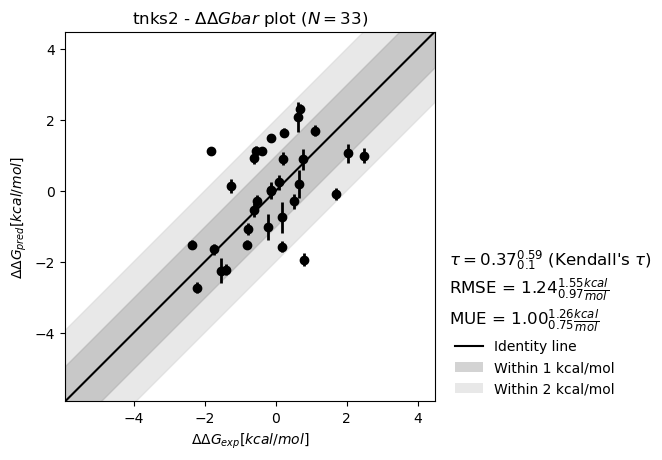

In [36]:
json_results = json.loads(Path("results/tnks2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tnks2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [37]:
fep_names = {}

chemio = MoleculeIO("perturbations/tnks2/ligands.sdf")
network_dict = json.loads(Path("perturbations/tnks2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-08-18 16:36:48 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1b. Reindexed.
2025-08-18 16:36:48 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 8b. Reindexed.


# Investigate the error

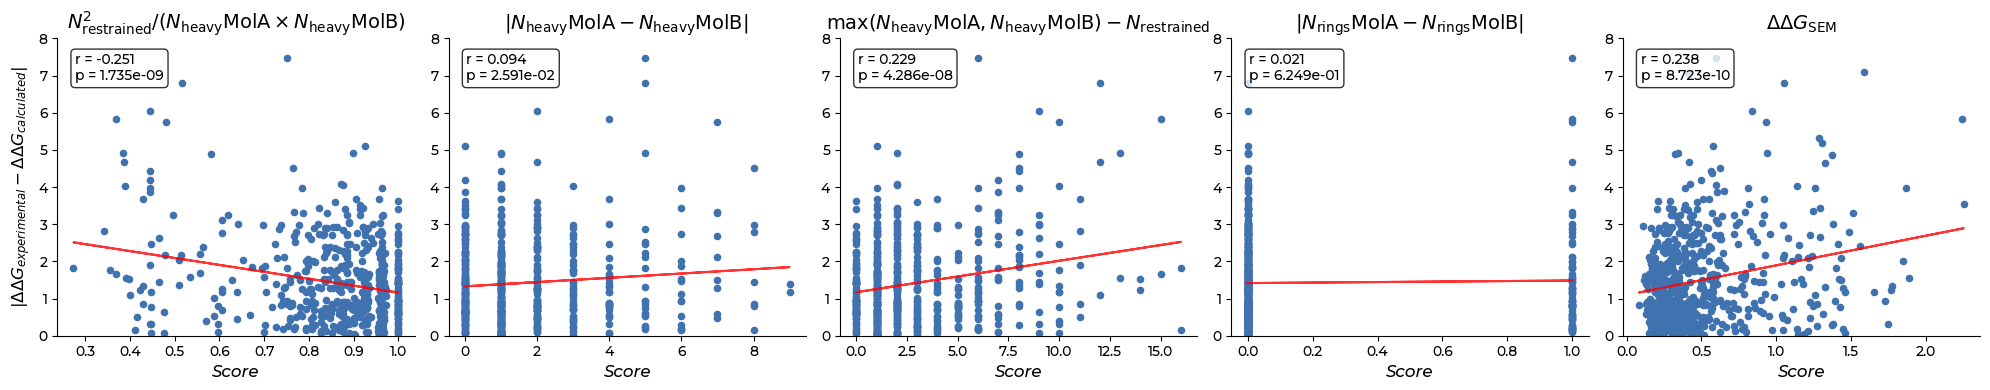

In [102]:
alldata = pd.concat(all_dataframes, ignore_index=True)
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))

titles = [
    ### Similarity
    r"$N_{\text{restrained}}^2 / (N_{\text{heavy}}\mathrm{MolA} \times N_{\text{heavy}}\mathrm{MolB})$",
    ### Atom Number Difference (\Delta N_{\text{atoms}} =)
    r"$|N_{\text{heavy}}\mathrm{MolA} - N_{\text{heavy}}\mathrm{MolB}|$ ",
    ### Unrestrained Atoms in the Bigger Molecule (U_{\text{bigger}} = )
    r"$ \max(N_{\text{heavy}}\mathrm{MolA}, N_{\text{heavy}}\mathrm{MolB}) - N_{\text{restrained}}$ ",
    ### Difference in Number of Rings (\Delta N_{\text{rings}} = )
    r"$|N_{\text{rings}}\mathrm{MolA} - N_{\text{rings}}\mathrm{MolB}|$",
    ### Perturbation SEM
    r"$\Delta\Delta G_{\text{SEM}}$",
]
conditions = ["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings", "Q_ddG_sem"]

for i, (title, x_col, ax) in enumerate(zip(titles, conditions, axs)):
    alldata.assign(abs_residual=lambda x: x["residual"].abs()).plot.scatter(
        x=x_col, y="abs_residual", ax=ax, color="#3F72AF"
    )

    data = alldata[[x_col, "residual"]].dropna()
    x = data[x_col]
    y = data["residual"].abs()

    correlation, p_value = stats.pearsonr(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), alpha=0.8, color="red")
    if i == 0:
        ax.set_ylabel(r"$|\Delta\Delta G_{experimental} - \Delta\Delta G_{calculated}|$")
        ax.set_title(f"{title}", size=20)
    else:
        ax.set_ylabel("")
        ax.set_title(f"{title}", size=14)

    ax.set_xlabel("Score")
    ax.set_ylim(0, 8)

    ax.text(
        0.05,
        0.95,
        f"r = {correlation:.3f}\np = {p_value:.3e}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontproperties=tick_font,
    )
    set_font_properties(ax)
    sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
fig = plt.gcf()
fig.savefig("figures/error-explanation.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/error-explanation.svg", bbox_inches="tight", facecolor="white")
plt.show()

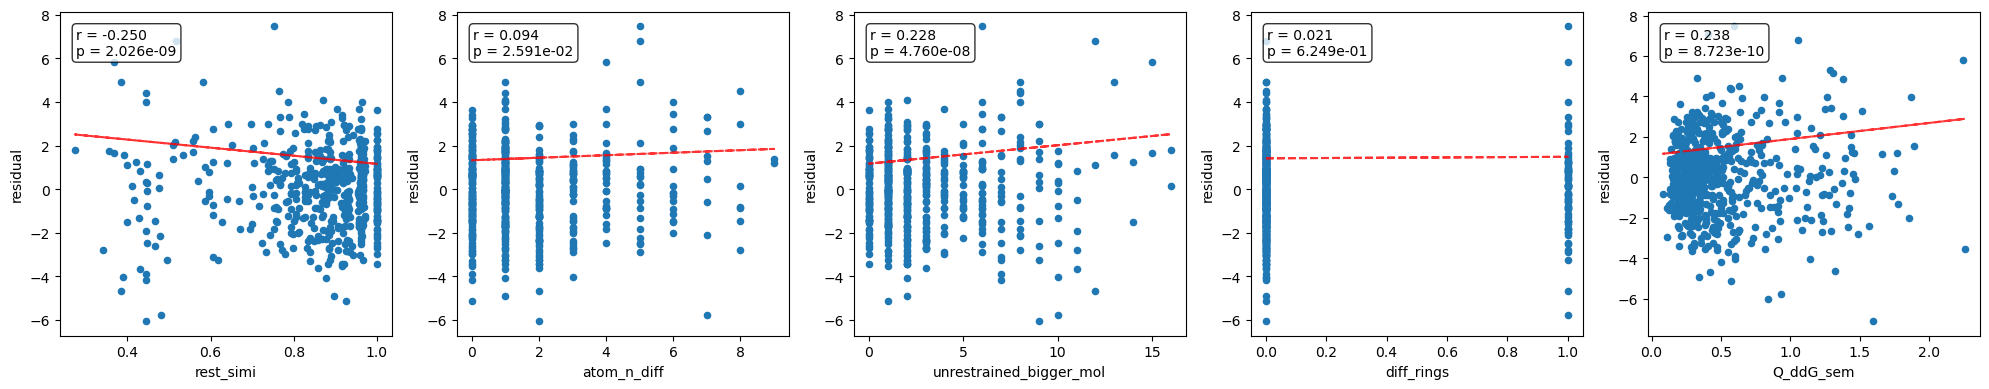

In [40]:
alldata = pd.concat(all_dataframes, ignore_index=True)
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))

for i, (x_col, ax) in enumerate(
    zip(["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings", "Q_ddG_sem"], axs)
):
    alldata.assign(abs_residual=lambda x: x["residual"].abs()).plot.scatter(x=x_col, y="residual", ax=ax)

    data = alldata[[x_col, "residual"]].dropna()
    x = data[x_col]
    y = data["residual"].abs()

    correlation, p_value = stats.pearsonr(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8)

    ax.text(
        0.05,
        0.95,
        f"r = {correlation:.3f}\np = {p_value:.3e}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

plt.tight_layout()

# Run stats

In [127]:
all_targets = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b",
    "thrombin",
    "tyk2",
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]

all_run_data = []

for target in all_targets:
    run_data = pd.read_parquet(
        f"results/{target}/{target.replace('ManualMapping', '')}_run_data.parquet"
    ).assign(target=target)
    all_run_data.append(run_data)

all_run_data = (
    pd.concat(all_run_data, ignore_index=True)
    .query("target != 'cdk8'")
    .assign(target=lambda x: x.target.replace({"cdk8ManualMapping": "cdk8"}))
)
print("Total number of FEP runs:", all_run_data.shape[0])

Total number of FEP runs: 13298


Successful and failed runs

In [128]:
print(
    (
        pd.crosstab(
            all_run_data["target"],
            all_run_data["comment"].replace({"CANCELLED": "OTHER", "TIMEOUT": "OTHER"}),
            normalize="index",
        )
        * 100
    )
    .apply(pd.Series.round, decimals=2)[["SUCCESS", "CRASHED", "OTHER"]]
    .apply(lambda x: x.astype(str) + "%")
    .to_markdown()
)

| target   | SUCCESS   | CRASHED   | OTHER   |
|:---------|:----------|:----------|:--------|
| bace     | 100.0%    | 0.0%      | 0.0%    |
| cdk2     | 100.0%    | 0.0%      | 0.0%    |
| cdk8     | 99.56%    | 0.44%     | 0.0%    |
| cmet     | 99.86%    | 0.14%     | 0.0%    |
| eg5      | 97.44%    | 2.44%     | 0.12%   |
| hif2a    | 100.0%    | 0.0%      | 0.0%    |
| jnk1     | 100.0%    | 0.0%      | 0.0%    |
| mcl1     | 96.77%    | 3.23%     | 0.0%    |
| p38      | 98.11%    | 1.89%     | 0.0%    |
| pfkfb3   | 92.59%    | 7.41%     | 0.0%    |
| ptp1b    | 100.0%    | 0.0%      | 0.0%    |
| shp2     | 100.0%    | 0.0%      | 0.0%    |
| syk      | 96.11%    | 3.81%     | 0.08%   |
| thrombin | 99.64%    | 0.0%      | 0.36%   |
| tnks2    | 99.52%    | 0.0%      | 0.48%   |
| tyk2     | 100.0%    | 0.0%      | 0.0%    |


/tmp/ipykernel_1157370/985080342.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(


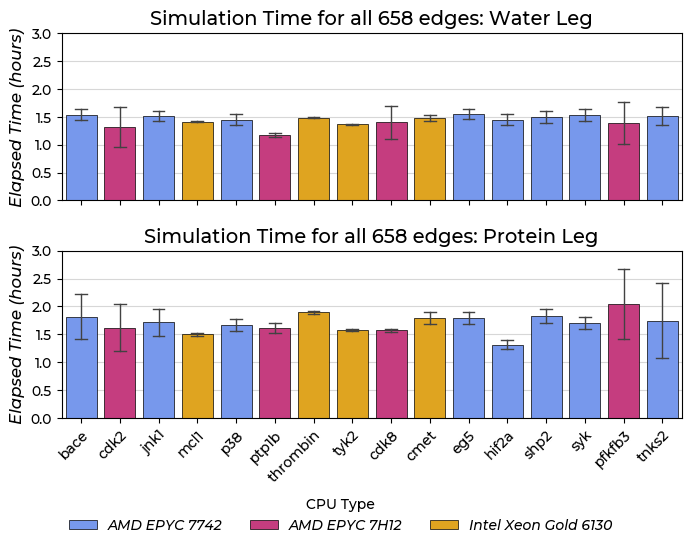

In [224]:
import matplotlib.colors as mcolors

colors = [
    "#648FFF",
    "#DC267F",
    "#FFB000",
]

rgb_colors = [mcolors.to_rgba(c) for c in colors]


def time_to_unit(time_str: str, unit: str = "seconds") -> float:
    hours = minutes = seconds = 0
    if "h" in time_str:
        hours = int(time_str.split("h")[0])
        time_str = time_str.split("h", 1)[1]
    if "m" in time_str:
        minutes = int(time_str.split("m")[0].split(":")[-1])
        time_str = time_str.split("m", 1)[1]
    if "s" in time_str:
        seconds = int(time_str.split("s")[0].split(":")[-1])
    total_seconds = hours * 3600 + minutes * 60 + seconds
    if unit.lower() == "seconds":
        return total_seconds
    elif unit.lower() == "minutes":
        return total_seconds / 60
    elif unit.lower() == "hours":
        return total_seconds / 3600
    else:
        raise ValueError("Invalid unit. Choose 'seconds', 'minutes', or 'hours'.")


targs = [t if t != "cdk8ManualMapping" else t.replace("cdk8ManualMapping", "cdk8") for t in all_targets]
targs_in_dardel = ["bace", "eg5", "hif2a", "jnk1", "p38", "shp2", "syk", "tnks2"]
targs_in_tetralith = ["thrombin", "tyk2", "mcl1", "cmet"]
cpu_mapping = {"dardel": "AMD EPYC 7742", "tetralith": "Intel Xeon Gold 6130", "snellius": "AMD EPYC 7H12"}
color_mapping = {
    "dardel": colors[0],
    "snellius": colors[1],
    "tetralith": colors[2],
}


def where_it_ran(target, dardel=targs_in_dardel, tetra=targs_in_tetralith):
    if target in dardel:
        return "dardel"
    elif target in tetra:
        return "tetralith"
    else:
        return "snellius"


transformed = (
    all_run_data.assign(
        elapsed=all_run_data["runtime"].fillna("0h0m0s").apply(time_to_unit, unit="hours"),
    )
    .assign(system=all_run_data["system"].replace({"1.water": "water", "2.protein": "protein"}))
    .query("comment == 'SUCCESS'")
    .assign(where_it_ran=all_run_data["target"].apply(where_it_ran))
)

# --- Seaborn plotting solution ---
fig, axs = plt.subplots(nrows=2, figsize=(8, 5), sharex=True)

for ax, system in zip(axs.flatten(), ["water", "protein"]):
    # Filter the data for the current system
    system_data = transformed.query("system == @system")

    # Create the boxplot using seaborn
    sns.barplot(
        data=system_data,
        x="target",
        y="elapsed",
        hue="where_it_ran",
        errorbar="sd",
        order=targs,  # Ensure the order of targets is consistent
        hue_order=color_mapping.keys(),  # Ensure consistent hue order
        palette=color_mapping,
        edgecolor="black",
        linewidth=0.5,
        capsize=0.3,
        err_kws={"linewidth": 1},
        ax=ax,
    )

    ax.set_title(f"Simulation Time for all {all_run_data.FEP.nunique()} edges: {system.capitalize()} Leg")
    ax.set_ylabel("Elapsed Time (hours)")
    ax.set_xlabel("")  # Hide x-label for the top plot
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    # Replace machine names with CPU names for the legend labels
    legend_labels = [cpu_mapping[label] for label in labels]
    if system == "water":
        ax.legend().set_visible(False)
    else:
        ax.legend(
            handles,
            legend_labels,
            title="CPU Type",
            loc="upper center",
            bbox_to_anchor=(0.45, -0.40),
            frameon=False,
            shadow=True,
            ncol=5,
        )
    # ax.legend(handles, legend_labels, title="CPU Type", bbox_to_anchor=(1.01, 1), loc="upper left")

# Set rotated x-tick labels only for the bottom plot
axs[1].set_xticklabels(
    targs,
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
axs[1].set_xlabel("")
axs[1].set_ylim(0, 3)
axs[0].set_ylim(0, 3)

set_font_properties(axs[0])
set_font_properties(axs[1])

plt.subplots_adjust(hspace=0.3)

fig.savefig("figures/simulation-time-per-target.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/simulation-time-per-target.svg", bbox_inches="tight", facecolor="white")

# Compare Results

## Imports & Functions

In [191]:
from scipy import stats
from sklearn.metrics import mean_squared_error


# adapted from https://github.com/OpenFreeEnergy/cinnabar/blob/main/cinnabar/stats.py
def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 1000,
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
) -> dict:
    """Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for confidence interval (CI)
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    include_true_uncertainty : bool, default False
        whether to account for the uncertainty in y_true when bootstrapping
    include_pred_uncertainty : bool, default False
        whether to account for the uncertainty in y_pred when bootstrapping

    Returns
    -------
    rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == "MUE":
            return mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = stats.linregress(y_true_sample, y_pred_sample)
            return r_value**2
        elif statistic == "rho":
            return stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    # not used?
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros([nbootstrap], np.float64)  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        # 1. Get all random indices for this replicate at once
        indices = np.random.choice(np.arange(sample_size), size=sample_size, replace=True)

        # 2. Create the resampled datasets using array indexing
        y_true_resampled = y_true[indices]
        y_pred_resampled = y_pred[indices]
        dy_true_resampled = dy_true[indices]
        dy_pred_resampled = dy_pred[indices]

        # 3. Add uncertainty in a vectorized way (if requested)
        if include_true_uncertainty:
            y_true_sample = np.random.normal(loc=y_true_resampled, scale=np.fabs(dy_true_resampled))
        else:
            y_true_sample = y_true_resampled

        if include_pred_uncertainty:
            y_pred_sample = np.random.normal(loc=y_pred_resampled, scale=np.fabs(dy_pred_resampled))
        else:
            y_pred_sample = y_pred_resampled

        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    low_percentile = (1.0 - ci) / 2.0 * 100
    high_percentile = (1.0 + ci) / 2.0 * 100
    rmse_stats["low"], rmse_stats["high"] = np.percentile(s_n, [low_percentile, high_percentile])
    return rmse_stats


def clean_latex_strings(text):
    """
    Find LaTeX-like strings with the form $value_{lower}^{upper}$
    and transform them by removing $, {, } symbols and replacing '^' with '_'.
    """
    pattern = r"\$([^\$_]+)_\{([^\}]+)\}\^\{([^\}]+)\}\$"

    def replacement(match):
        value, lower, upper = match.groups()
        return f"{value}_{lower}_{upper}"

    return re.sub(pattern, replacement, text)


def take_value(string, which="sub"):
    values = string.split("_")
    if which == "mean":
        return float(values[0])
    elif which == "sub":
        return float(values[1])
    elif which == "sup":
        return float(values[2])


def get_metrics_df(
    results_df: pd.DataFrame,
    statistics: list,
    targets: list,
    pred_col: str,
    exp_col: str,
):
    results_dict = {}
    for stat in statistics + ["N"]:
        dictionary = {stat: {}}
        for target in targets:
            subset = results_df.query("target == @target")
            if stat == "N":
                dictionary[stat][target] = len(subset)
                continue

            res = bootstrap_statistic(subset[pred_col].values, subset[exp_col].values, statistic=stat)

            def result_to_latex(res):
                # Round to one decimal
                mle = round(res["mle"], 2)
                low = round(res["low"], 2)
                high = round(res["high"], 2)

                # Generate the LaTeX string
                return f"${mle}_{{{low}}}^{{{high}}}$"

            latex = result_to_latex(res)
            dictionary[stat][target] = latex
        results_dict.update(dictionary)
    metrics_df = pd.DataFrame().from_dict(results_dict)
    return metrics_df


def plot_single_point_metrics(
    single_point_df: pd.DataFrame,
    calc_col: str = "Q_ddG_avg",
    exp_col: str = "ddg_value",
    target_col: str = "target",
    metrics: list = ["KTAU", "MAE"],
    figsize: tuple = (8, 6),
):
    """
    Plot single-point metrics for JACS and Merck targets.

    Parameters:
        single_point_df: DataFrame containing the single-point metrics.
        calc_col: Column name for calculated values.
        exp_col: Column name for experimental values.
        target_col: Column name for target identifiers.
        metrics): List of metrics to plot.
        figsizee): Size of the figure.
    """

    single_point = []

    for target in single_point_df[target_col].unique():
        ktau = kendalltau(
            x=single_point_df.query(f"{target_col}==@target")[calc_col],
            y=single_point_df.query(f"{target_col}==@target")[exp_col],
        )[0]
        mae = mean_absolute_error(
            y_true=single_point_df.query(f"{target_col}==@target")[exp_col],
            y_pred=single_point_df.query(f"{target_col}==@target")[calc_col],
        )
        single_point.append([target, ktau, mae])

    single_point_df = pd.DataFrame(single_point, columns=["target", "KTAU", "MAE"]).set_index("target")

    fig, axs = plt.subplots(nrows=len(metrics), figsize=figsize)

    colors = ["skyblue", "lightcoral"]
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        single_point_df[metric].plot(
            kind="bar", ax=axs[i], color=color, rot=45, ylabel=metric, edgecolor="black"
        )
        axs[i].set_title(f"Single-point {metric} for JACS and Merck targets")
        axs[i].grid(axis="y", alpha=0.3)
        axs[i].set_axisbelow(True)

    plt.tight_layout()

## Load our data

In [192]:
jacs_targs = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b2xSampled",
    "thrombin",
    "tyk2",
]
merck_targs = [
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]
targets = jacs_targs + merck_targs

In [193]:
qligfep_result_df = []

for targ in targets:
    fpath = Path(f"results/{targ}/mapping_ddG.json")
    if not fpath.exists():
        print(f"Skipping {targ}")
        continue

    json_results = json.loads(fpath.read_text())

    df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()").assign(target=targ)

    qligfep_result_df.append(df)

qligfep_result_df = pd.concat(qligfep_result_df).assign(
    target=lambda x: x["target"].replace({"ptp1b2xSampled": "ptp1b", "cdk8ManualMapping": "cdk8"})
)

# Calculate $\Delta G$ from $\Delta\Delta G$

In [194]:
import networkx as nx


def get_most_connected_node(data, lig1col="from", lig2col="to", ddG_col="Q_ddG_avg"):
    G = nx.DiGraph()
    for _, edge in data.iterrows():
        G.add_edge(edge[lig1col], edge[lig2col], weight=edge[ddG_col])
        G.add_edge(edge[lig2col], edge[lig1col], weight=-edge[ddG_col])
    most_connected = max(G.degree, key=lambda x: x[1])[0]
    return most_connected


def load_single_node_dG(mapping_path, node_name):
    mapping_dict = json.loads(mapping_path.read_text())
    return mapping_dict["nodes"][node_name]["dg_value"]


def find_connected_components(data, from_col="from", to_col="to"):
    """
    Identifies disconnected subgraphs (connected components) in the data.

    Args:
        data (pd.DataFrame): DataFrame containing the edge list.
        from_col (str): The name of the column representing the starting node of an edge.
        to_col (str): The name of the column representing the ending node of an edge.

    Returns:
        tuple: A tuple containing:
            - int: The number of disconnected components (subgraphs).
            - list: A list of lists, where each inner list contains the
                    original DataFrame indices of the edges belonging to one component.
    """
    G = nx.from_pandas_edgelist(data, source=from_col, target=to_col)
    component_nodes = list(nx.connected_components(G))

    component_indices = []
    for nodes in component_nodes:
        mask = data[from_col].isin(nodes) & data[to_col].isin(nodes)

        indices = data.index[mask].tolist()
        component_indices.append(indices)

    return (len(component_nodes), component_indices)

## Cycle closure correction for QligFEP results
For this, we use the [State Function-Based Correction](https://doi.org/10.1021/acs.jpclett.5c01119) method.

To install, run: `python -m pip install git+https://github.com/David-Araripe/SFC_FreeEnergyCorrection.git`

<!-- # Before I was doing with the `WeightedCCC` package, but it was slow for D. Hahn's data, so I'm using `SFC_FreeEnergyCorrection`. I'm adding the code here because of my FOMO... What if we need it later?

from WeightedCCC.graph import GraphClosure
from WeightedCCC.calc_lig import (
    set_node_map,
    cal_node_path_independent_error,
    cal_node_path_dependent_error,
    calcMolEnes,
    getMolEnergyDataFrame,
)

qligfep_dG_dfs = []

for target in qligfep_result_df.target.unique():
    print(target)

    target_subset = qligfep_result_df.query("target == @target").copy()
    n_subgraphs, idxs = find_connected_components(target_subset)

    if n_subgraphs > 1:
        print(f"Found {n_subgraphs} disconnected components in {target}. Processing one at a time.")

    for sub_idxs in idxs:
        subtraph_subset = target_subset.loc[sub_idxs].copy()

        g = GraphClosure(
            from_lig=subtraph_subset["from"].tolist(),
            to_lig=subtraph_subset["to"].tolist(),
            b_ddG=subtraph_subset["Q_ddG_avg"].tolist(),
            # weights=qligfep_result_df["Q_ddG_sem"].tolist(),
        )

        most_connected = get_most_connected_node(subtraph_subset)
        path_template = Path("results/{target}/mapping_ddG.json".format(target=target))

        ref_dG = load_single_node_dG(path_template, most_connected)

        g.getAllCyles()
        g.iterateCycleClosure(minimum_cycles=2)
        # g.getEnergyPairsDataFrame(verbose=True)
        node_map = set_node_map(g)
        path_independent_error = cal_node_path_independent_error(g.V, node_map)
        path_dependent_error, path = cal_node_path_dependent_error(most_connected, g.V, node_map)
        mol_ene = calcMolEnes(ref_dG, g, path)
        ene_df = getMolEnergyDataFrame(
            g.V, mol_ene, path_dependent_error, path_independent_error, verbose=False
        )
        qligfep_dG_dfs.append(ene_df.assign(target=target))

qligfep_dG_dfs = pd.concat(qligfep_dG_dfs, ignore_index=True)

 -->

 <!-- Another option is doing it with MLE, the methods used in Hahn et al's paper.
 I tried it but it seems less robsut than the SFC method. Here's the code I tried (FOMO):

 from cinnabar import femap
from openff.units import unit
from cinnabar import ReferenceState, Measurement

mapping_path = Path("results/bace/mapping_ddG.json")


def add_dG_to_mapping_file(mapping_path):

    mapping_dict = json.loads(mapping_path.read_text())

    nodes = pd.DataFrame.from_dict(mapping_dict["nodes"], orient="index").reset_index(names="ligand")
    edges = pd.DataFrame(mapping_dict["edges"])

    kcalmol = unit.kilocalorie_per_mole
    g = ReferenceState()
    fe = femap.FEMap()

    for _, row in nodes.iterrows():
        fe.add_measurement(
            Measurement(
                labelA=g,
                labelB=row["ligand"],
                DG=row["dg_value"] * kcalmol,
                uncertainty=0.0 * kcalmol,
                computational=False,
            )
        )
    for _, row in edges.iterrows():
        if pd.isna(row["Q_ddG_avg"]):
            continue
        else:
            fe.add_measurement(
                Measurement(
                    labelA=row["from"],
                    labelB=row["to"],
                    DG=row["Q_ddG_avg"] * kcalmol,
                    uncertainty=row["Q_ddG_sem"] * kcalmol,
                    computational=True,
                )
            )

    fe.generate_absolute_values()
    df = fe.get_absolute_dataframe().query('source == "MLE"')

    Q_dG_values = (
        df.set_index("label")
        .rename(columns={"DG (kcal/mol)": "QdG", "uncertainty (kcal/mol)": "Q-SEMdG"})
        .drop(columns=["source", "computational"])
        .to_dict(orient="index")
    )

    for node in mapping_dict["nodes"]:
        try:
            mapping_dict["nodes"][node]["QdG"] = Q_dG_values[node]["QdG"]
        except KeyError:
            mapping_dict["nodes"][node]["QdG"] = None
        try:
            mapping_dict["nodes"][node]["Q-SEMdG"] = Q_dG_values[node]["QdG"]
        except KeyError:
            mapping_dict["nodes"][node]["Q-SEMdG"] = None

    with mapping_path.open("w"):
        json.dump(mapping_dict, mapping_path.open("w"), indent=2)
    return mapping_dict


all_mapping_files = sorted(Path().glob("results/*/mapping_ddG.json"))
for mapfile in all_mapping_files:
    print(f"Processing {mapfile}")
    try:
        add_dG_to_mapping_file(mapfile)
    except ValueError as e:
        print(f"Skipping {mapfile} due to error: {e}")
        continue
    
>>> Processing results/bace/mapping_ddG.json
>>> Processing results/cdk2/mapping_ddG.json
>>> Processing results/cdk8/mapping_ddG.json
>>> Processing results/cdk8ManualMapping/mapping_ddG.json
>>> Processing results/cmet/mapping_ddG.json
>>> Skipping results/cmet/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/eg5/mapping_ddG.json
>>> Skipping results/eg5/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/hif2a/mapping_ddG.json
>>> Skipping results/hif2a/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/jnk1/mapping_ddG.json
>>> Processing results/mcl1/mapping_ddG.json
>>> Processing results/p38/mapping_ddG.json
>>> Processing results/pfkfb3/mapping_ddG.json
>>> Processing results/ptp1b/mapping_ddG.json
>>> Processing results/ptp1b2xSampled/mapping_ddG.json
>>> Processing results/shp2/mapping_ddG.json
>>> Processing results/syk/mapping_ddG.json
>>> Skipping results/syk/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/thrombin/mapping_ddG.json
>>> Processing results/tnks2/mapping_ddG.json
>>> Skipping results/tnks2/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/tyk2/mapping_ddG.json
  -->

In [195]:
from SFC_FreeEnergyCorrection.data_loader import DataLoader
from SFC_FreeEnergyCorrection.apply_sfc import run_and_process_results

qligfep_dG_dfs = []

for target in qligfep_result_df.target.unique():
    print(target)

    target_subset = qligfep_result_df.query("target == @target").copy()
    n_subgraphs, idxs = find_connected_components(target_subset)

    if n_subgraphs > 1:
        print(f"Found {n_subgraphs} disconnected components in {target}. Processing one at a time.")

    for sub_idxs in idxs:
        subtraph_subset = target_subset.loc[sub_idxs].copy()

        most_connected = get_most_connected_node(subtraph_subset)
        path_template = Path("results/{target}/mapping_ddG.json".format(target=target))

        ref_dG = load_single_node_dG(path_template, most_connected)

        dl = DataLoader(
            from_lig=subtraph_subset["from"].tolist(),
            to_lig=subtraph_subset["to"].tolist(),
            b_ddG=subtraph_subset["Q_ddG_avg"].tolist(),
            err_b_ddG=qligfep_result_df["Q_ddG_sem"].tolist(),
            ref_mol=most_connected,
        )

        result = run_and_process_results(dl, ref_energy=ref_dG, include_pairs=True)
        ene_df = result["sfc"]["node_results"]
        qligfep_dG_dfs.append(ene_df.assign(target=target))

qligfep_dG_dfs = pd.concat(qligfep_dG_dfs, ignore_index=True)

2025-08-18 18:33:47,508 - INFO - Rank check: rank(A) = 37, N = 38
2025-08-18 18:33:47,508 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:47,509 - INFO - cond(A_aug) [SFC check] = 2.38e+01
2025-08-18 18:33:47,509 - INFO - cond(Aw_aug) [WSFC check] = 1.75e+03
2025-08-18 18:33:47,509 - WARNING - cond(Aw_aug) = 1.75e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:47,510 - INFO - Running Standard Optimization mode...


bace


2025-08-18 18:33:47,786 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:47,794 - INFO - Rank check: rank(A) = 15, N = 16
2025-08-18 18:33:47,794 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:47,795 - INFO - cond(A_aug) [SFC check] = 1.34e+01
2025-08-18 18:33:47,795 - INFO - cond(Aw_aug) [WSFC check] = 3.59e+02
2025-08-18 18:33:47,796 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:47,824 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:47,831 - INFO - Rank check: rank(A) = 20, N = 21
2025-08-18 18:33:47,831 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:47,831 - INFO - cond(A_aug) [SFC check] = 1.65e+01
2025-08-18 18:33:47,832 - INFO - cond(Aw_aug) [WSFC check] = 5.01e+02
2025-08-18 18:33:47,833 - INFO - Running St

cdk2
jnk1
mcl1


2025-08-18 18:33:48,176 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,186 - INFO - Rank check: rank(A) = 33, N = 34
2025-08-18 18:33:48,187 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,187 - INFO - cond(A_aug) [SFC check] = 2.43e+01
2025-08-18 18:33:48,188 - INFO - cond(Aw_aug) [WSFC check] = 1.66e+03
2025-08-18 18:33:48,189 - WARNING - cond(Aw_aug) = 1.66e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:48,189 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:48,347 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,355 - INFO - Rank check: rank(A) = 22, N = 23
2025-08-18 18:33:48,356 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,356 - INFO - cond(A_aug) [SFC check] = 1.7

p38
ptp1b


2025-08-18 18:33:48,439 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,446 - INFO - Rank check: rank(A) = 10, N = 11
2025-08-18 18:33:48,446 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,446 - INFO - cond(A_aug) [SFC check] = 9.99e+00
2025-08-18 18:33:48,447 - INFO - cond(Aw_aug) [WSFC check] = 1.92e+02
2025-08-18 18:33:48,447 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:48,462 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,468 - INFO - Rank check: rank(A) = 15, N = 16
2025-08-18 18:33:48,468 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,468 - INFO - cond(A_aug) [SFC check] = 1.36e+01
2025-08-18 18:33:48,469 - INFO - cond(Aw_aug) [WSFC check] = 3.55e+02
2025-08-18 18:33:48,469 - INFO - Running St

thrombin
tyk2
cdk8
cmet
Found 2 disconnected components in cmet. Processing one at a time.


2025-08-18 18:33:48,649 - INFO - Rank check: rank(A) = 11, N = 12
2025-08-18 18:33:48,649 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,649 - INFO - cond(A_aug) [SFC check] = 1.09e+01
2025-08-18 18:33:48,650 - INFO - cond(Aw_aug) [WSFC check] = 2.93e+02
2025-08-18 18:33:48,650 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:48,666 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,670 - INFO - Rank check: rank(A) = 11, N = 12
2025-08-18 18:33:48,670 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,670 - INFO - cond(A_aug) [SFC check] = 1.00e+01
2025-08-18 18:33:48,671 - INFO - cond(Aw_aug) [WSFC check] = 2.15e+02
2025-08-18 18:33:48,671 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:48,691 - INFO - Energy calculations completed (engine mode: optimize, weigh

eg5
Found 2 disconnected components in eg5. Processing one at a time.
hif2a
Found 2 disconnected components in hif2a. Processing one at a time.


2025-08-18 18:33:48,911 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,915 - INFO - Rank check: rank(A) = 7, N = 8
2025-08-18 18:33:48,915 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,916 - INFO - cond(A_aug) [SFC check] = 7.50e+00
2025-08-18 18:33:48,916 - INFO - cond(Aw_aug) [WSFC check] = 9.98e+01
2025-08-18 18:33:48,916 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:48,925 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:48,932 - INFO - Rank check: rank(A) = 25, N = 26
2025-08-18 18:33:48,932 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:48,933 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-08-18 18:33:48,934 - INFO - cond(Aw_aug) [WSFC check] = 8.56e+02
2025-08-18 18:33:48,934 - INFO - Running Stan

shp2
syk
Found 3 disconnected components in syk. Processing one at a time.


2025-08-18 18:33:49,191 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:49,195 - INFO - Rank check: rank(A) = 4, N = 5
2025-08-18 18:33:49,195 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:49,196 - INFO - cond(A_aug) [SFC check] = 5.64e+00
2025-08-18 18:33:49,196 - INFO - cond(Aw_aug) [WSFC check] = 3.36e+01
2025-08-18 18:33:49,196 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:49,202 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:49,209 - INFO - Rank check: rank(A) = 37, N = 38
2025-08-18 18:33:49,210 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:49,210 - INFO - cond(A_aug) [SFC check] = 2.70e+01
2025-08-18 18:33:49,211 - INFO - cond(Aw_aug) [WSFC check] = 1.49e+03
2025-08-18 18:33:49,211 - WARNING - cond(Aw_a

pfkfb3
tnks2
Found 2 disconnected components in tnks2. Processing one at a time.


2025-08-18 18:33:49,406 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:49,453 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:49,456 - INFO - Rank check: rank(A) = 5, N = 6
2025-08-18 18:33:49,457 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:49,457 - INFO - cond(A_aug) [SFC check] = 6.27e+00
2025-08-18 18:33:49,458 - INFO - cond(Aw_aug) [WSFC check] = 4.74e+01
2025-08-18 18:33:49,458 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:49,464 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).


In [196]:
qligfep_dG_dfs = qligfep_dG_dfs.rename(
    columns={
        "Ligand": "Node",
        "Energy": "sfc_dG",
        "Path_Dep_Error": "path_dep_error",
        "Path_Indep_Error": "path_indep_error",
    },
)

In [197]:
single_node_exp_values = []
for target in qligfep_dG_dfs.target.unique():
    path_template = Path("results/{target}/mapping_ddG.json".format(target=target))
    single_node_df = (
        pd.DataFrame.from_dict(json.loads(path_template.read_text())["nodes"], orient="index")
        .assign(target=target)
        .reset_index(names=["Node"])
    )
    single_node_exp_values.append(single_node_df[["Node", "dg_value", "target"]])

single_node_exp_values = pd.concat(single_node_exp_values)
qligfep_dG_dfs = qligfep_dG_dfs.merge(
    single_node_exp_values,
    on=["target", "Node"],
    how="left",
)

In [198]:
# plot_single_point_metrics(qligfep_dG_dfs, calc_col="sfc_dG", exp_col="dg_value")
# plot_single_point_metrics(qligfep_result_df, calc_col="Q_ddG_avg", exp_col="ddg_value", target_col="target")

## Fetch other data for comparison

In [199]:
html_root = "https://raw.githubusercontent.com/dfhahn/protein-ligand-benchmark-analysis/refs/heads/master"

res = requests.get(f"{html_root}/03_comparison_experiment/03a_all_edges_all_ffs.csv")
res.raise_for_status()

targets = pd.Series(targets).replace({"ptp1b2xSampled": "ptp1b", "cdk8ManualMapping": "cdk8"}).tolist()
hahn_results = (
    pd.read_csv(StringIO(res.text), index_col=0).reset_index(names=["FEP_ID"]).query("target.isin(@targets)")
)

res = requests.get(f"{html_root}/03_comparison_experiment/03b_all_ligands_all_ffs.csv")
res.raise_for_status()
hahn_nodes = (
    pd.read_csv(StringIO(res.text), index_col=0).reset_index(names=["FEP_ID"]).query("target.isin(@targets)")
)

In [200]:
hahn_results.columns

Index(['FEP_ID', 'target', 'edge', 'ligandA', 'ligandB', 'unit', 'DDG_Exp.',
       'dDDG_Exp.', 'DDG_OpenFF-1.0', 'dDDG_OpenFF-1.0',
       'DDG_OpenFF-1.0_converged', 'dDDG_OpenFF-1.0_converged',
       'DDG_OpenFF-1.2', 'dDDG_OpenFF-1.2', 'DDG_OpenFF-1.2_converged',
       'dDDG_OpenFF-1.2_converged', 'DDG_OpenFF-2.0', 'dDDG_OpenFF-2.0',
       'DDG_OpenFF-2.0_converged', 'dDDG_OpenFF-2.0_converged', 'DDG_OPLS3e',
       'dDDG_OPLS3e', 'DDG_GAFF2', 'dDDG_GAFF2', 'DDG_cGenFF', 'dDDG_cGenFF',
       'DDG_Consensus_OpenFF_GAFF2_cGenFF',
       'dDDG_Consensus_OpenFF_GAFF2_cGenFF', 'DDG_Consensus_OpenFF_GAFF2',
       'dDDG_Consensus_OpenFF_GAFF2', 'DDG_Consensus_all',
       'dDDG_Consensus_all', 'error_OpenFF-1.0', 'abserror_OpenFF-1.0',
       'error_OpenFF-1.0_converged', 'abserror_OpenFF-1.0_converged',
       'error_OpenFF-1.2', 'abserror_OpenFF-1.2', 'error_OpenFF-1.2_converged',
       'abserror_OpenFF-1.2_converged', 'error_OpenFF-2.0',
       'abserror_OpenFF-2.0', 'error_Open

In [201]:
hahn_results["OpenFF20_residual"] = hahn_results["DDG_Exp."] - hahn_results["DDG_OpenFF-2.0"]
hahn_results["OPLS3e_residual"] = hahn_results["DDG_Exp."] - hahn_results["DDG_OPLS3e"]

## Cycle Closure Correction for D. Hahn's results

In [202]:
from itertools import product

dHahn_dG_dfs = []

values = ["DDG_OpenFF-2.0", "DDG_OPLS3e"]

for val, target in product(values, targets):
    print(target)

    target_subset = hahn_results.query("target == @target").dropna(subset=[val]).copy()
    n_subgraphs, idxs = find_connected_components(target_subset, from_col="ligandA", to_col="ligandB")

    if n_subgraphs > 1:
        print(f"Found {n_subgraphs} disconnected components in {target}. Processing one at a time.")

    for sub_idxs in idxs:
        subtraph_subset = target_subset.loc[sub_idxs].copy()

        most_connected = get_most_connected_node(
            subtraph_subset, lig1col="ligandA", lig2col="ligandB", ddG_col=val
        )

        path_template = Path("results/{target}/mapping_ddG.json".format(target=target))

        if most_connected == "SHP099-1":  # I don't know why but it's named like this
            ref_dG = load_single_node_dG(path_template, "SHP099-1-Example-7")
        else:
            ref_dG = load_single_node_dG(path_template, most_connected.replace(f"{target}a_", ""))

        dl = DataLoader(
            from_lig=subtraph_subset["ligandA"].tolist(),
            to_lig=subtraph_subset["ligandB"].tolist(),
            b_ddG=subtraph_subset[val].tolist(),
            err_b_ddG=subtraph_subset[f"d{val}"].tolist(),
            ref_mol=most_connected,
        )

        result = run_and_process_results(dl, ref_energy=ref_dG, include_pairs=True)
        ene_df = result["sfc"]["node_results"]
        dHahn_dG_dfs.append(ene_df.assign(target=target, value=val))

dHahn_dG_dfs = pd.concat(dHahn_dG_dfs, ignore_index=True)

2025-08-18 18:33:53,131 - INFO - Rank check: rank(A) = 35, N = 36
2025-08-18 18:33:53,131 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:53,132 - INFO - cond(A_aug) [SFC check] = 2.43e+01
2025-08-18 18:33:53,133 - INFO - cond(Aw_aug) [WSFC check] = 3.41e+03
2025-08-18 18:33:53,133 - WARNING - cond(Aw_aug) = 3.41e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:53,133 - INFO - Running Standard Optimization mode...


bace


2025-08-18 18:33:53,399 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:53,413 - INFO - Rank check: rank(A) = 15, N = 16
2025-08-18 18:33:53,413 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:53,413 - INFO - cond(A_aug) [SFC check] = 1.33e+01
2025-08-18 18:33:53,414 - INFO - cond(Aw_aug) [WSFC check] = 5.78e+02
2025-08-18 18:33:53,415 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:53,444 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:53,457 - INFO - Rank check: rank(A) = 20, N = 21
2025-08-18 18:33:53,457 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:53,458 - INFO - cond(A_aug) [SFC check] = 1.69e+01
2025-08-18 18:33:53,458 - INFO - cond(Aw_aug) [WSFC check] = 9.62e+02
2025-08-18 18:33:53,459 - INFO - Running St

cdk2
jnk1
mcl1


2025-08-18 18:33:53,862 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:53,877 - INFO - Rank check: rank(A) = 33, N = 34
2025-08-18 18:33:53,877 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:53,878 - INFO - cond(A_aug) [SFC check] = 2.57e+01
2025-08-18 18:33:53,878 - INFO - cond(Aw_aug) [WSFC check] = 3.00e+03
2025-08-18 18:33:53,879 - WARNING - cond(Aw_aug) = 3.00e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:53,879 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:54,069 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).


p38
ptp1b


2025-08-18 18:33:54,083 - INFO - Rank check: rank(A) = 22, N = 23
2025-08-18 18:33:54,083 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:54,084 - INFO - cond(A_aug) [SFC check] = 1.81e+01
2025-08-18 18:33:54,085 - INFO - cond(Aw_aug) [WSFC check] = 1.86e+03
2025-08-18 18:33:54,085 - WARNING - cond(Aw_aug) = 1.86e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:54,085 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:54,183 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:54,194 - INFO - Rank check: rank(A) = 10, N = 11
2025-08-18 18:33:54,194 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:54,195 - INFO - cond(A_aug) [SFC check] = 1.04e+01
2025-08-18 18:33:54,195 - INFO - cond(Aw_aug) [WSFC check] = 2.71e+02
2025-08-18 18:33:54,195 - INFO - Running Sta

thrombin
tyk2
cdk8
cmet


2025-08-18 18:33:54,404 - INFO - Rank check: rank(A) = 23, N = 24
2025-08-18 18:33:54,405 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:54,405 - INFO - cond(A_aug) [SFC check] = 1.76e+01
2025-08-18 18:33:54,406 - INFO - cond(Aw_aug) [WSFC check] = 5.27e+03
2025-08-18 18:33:54,406 - WARNING - cond(Aw_aug) = 5.27e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:54,407 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:54,551 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:54,565 - INFO - Rank check: rank(A) = 27, N = 28
2025-08-18 18:33:54,565 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:54,566 - INFO - cond(A_aug) [SFC check] = 1.98e+01
2025-08-18 18:33:54,567 - INFO - cond(Aw_aug) [WSFC check] = 7.52e+03
2025-08-18 18:33:54,567 - WARNING - cond(Aw_

eg5
hif2a


2025-08-18 18:33:54,946 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:54,962 - INFO - Rank check: rank(A) = 25, N = 26
2025-08-18 18:33:54,962 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:54,963 - INFO - cond(A_aug) [SFC check] = 2.07e+01
2025-08-18 18:33:54,964 - INFO - cond(Aw_aug) [WSFC check] = 2.84e+03
2025-08-18 18:33:54,964 - WARNING - cond(Aw_aug) = 2.84e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:54,964 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:55,084 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:55,101 - INFO - Rank check: rank(A) = 43, N = 44
2025-08-18 18:33:55,101 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:55,102 - INFO - cond(A_aug) [SFC check] = 2.5

shp2
syk


2025-08-18 18:33:55,506 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:55,521 - INFO - Rank check: rank(A) = 39, N = 40
2025-08-18 18:33:55,522 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:55,523 - INFO - cond(A_aug) [SFC check] = 2.44e+01
2025-08-18 18:33:55,523 - INFO - cond(Aw_aug) [WSFC check] = 3.82e+03
2025-08-18 18:33:55,524 - WARNING - cond(Aw_aug) = 3.82e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:55,524 - INFO - Running Standard Optimization mode...


pfkfb3


2025-08-18 18:33:55,761 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:55,775 - INFO - Rank check: rank(A) = 26, N = 27
2025-08-18 18:33:55,775 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:55,776 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-08-18 18:33:55,777 - INFO - cond(Aw_aug) [WSFC check] = 2.47e+03
2025-08-18 18:33:55,777 - WARNING - cond(Aw_aug) = 2.47e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:55,777 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:55,873 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:55,887 - INFO - Rank check: rank(A) = 35, N = 36
2025-08-18 18:33:55,887 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:55,888 - INFO - cond(A_aug) [SFC check] = 2.4

tnks2
bace


2025-08-18 18:33:56,162 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:56,174 - INFO - Rank check: rank(A) = 15, N = 16
2025-08-18 18:33:56,174 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:56,174 - INFO - cond(A_aug) [SFC check] = 1.33e+01
2025-08-18 18:33:56,175 - INFO - cond(Aw_aug) [WSFC check] = 4.68e+02
2025-08-18 18:33:56,175 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:56,200 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:56,211 - INFO - Rank check: rank(A) = 20, N = 21
2025-08-18 18:33:56,212 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:56,212 - INFO - cond(A_aug) [SFC check] = 1.69e+01
2025-08-18 18:33:56,213 - INFO - cond(Aw_aug) [WSFC check] = 9.64e+02
2025-08-18 18:33:56,213 - INFO - Running St

cdk2
jnk1
mcl1


2025-08-18 18:33:56,718 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:56,731 - INFO - Rank check: rank(A) = 33, N = 34
2025-08-18 18:33:56,732 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:56,732 - INFO - cond(A_aug) [SFC check] = 2.57e+01
2025-08-18 18:33:56,733 - INFO - cond(Aw_aug) [WSFC check] = 2.62e+03
2025-08-18 18:33:56,733 - WARNING - cond(Aw_aug) = 2.62e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:56,734 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:56,913 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:56,926 - INFO - Rank check: rank(A) = 22, N = 23


p38
ptp1b


2025-08-18 18:33:56,926 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:56,927 - INFO - cond(A_aug) [SFC check] = 1.81e+01
2025-08-18 18:33:56,928 - INFO - cond(Aw_aug) [WSFC check] = 1.44e+03
2025-08-18 18:33:56,928 - WARNING - cond(Aw_aug) = 1.44e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:56,928 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:57,001 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:57,012 - INFO - Rank check: rank(A) = 10, N = 11
2025-08-18 18:33:57,012 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:57,012 - INFO - cond(A_aug) [SFC check] = 1.04e+01
2025-08-18 18:33:57,013 - INFO - cond(Aw_aug) [WSFC check] = 2.26e+02
2025-08-18 18:33:57,013 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:57,028 - INFO - Energy

thrombin
tyk2
cdk8
cmet


2025-08-18 18:33:57,284 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:57,297 - INFO - Rank check: rank(A) = 27, N = 28
2025-08-18 18:33:57,298 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:57,298 - INFO - cond(A_aug) [SFC check] = 1.98e+01
2025-08-18 18:33:57,299 - INFO - cond(Aw_aug) [WSFC check] = 3.16e+03
2025-08-18 18:33:57,299 - WARNING - cond(Aw_aug) = 3.16e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:57,300 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:57,399 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:57,414 - INFO - Rank check: rank(A) = 41, N = 42
2025-08-18 18:33:57,414 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:57,415 - INFO - cond(A_aug) [SFC check] = 2.2

eg5
hif2a


2025-08-18 18:33:57,615 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:57,629 - INFO - Rank check: rank(A) = 25, N = 26
2025-08-18 18:33:57,629 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:57,630 - INFO - cond(A_aug) [SFC check] = 2.07e+01
2025-08-18 18:33:57,631 - INFO - cond(Aw_aug) [WSFC check] = 1.75e+03
2025-08-18 18:33:57,631 - WARNING - cond(Aw_aug) = 1.75e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:57,631 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:57,708 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:57,723 - INFO - Rank check: rank(A) = 43, N = 44
2025-08-18 18:33:57,723 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:57,724 - INFO - cond(A_aug) [SFC check] = 2.5

shp2
syk


2025-08-18 18:33:58,026 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:58,040 - INFO - Rank check: rank(A) = 39, N = 40
2025-08-18 18:33:58,041 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:58,041 - INFO - cond(A_aug) [SFC check] = 2.44e+01
2025-08-18 18:33:58,042 - INFO - cond(Aw_aug) [WSFC check] = 2.30e+03
2025-08-18 18:33:58,042 - WARNING - cond(Aw_aug) = 2.30e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-08-18 18:33:58,043 - INFO - Running Standard Optimization mode...
2025-08-18 18:33:58,211 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-08-18 18:33:58,225 - INFO - Rank check: rank(A) = 26, N = 27
2025-08-18 18:33:58,225 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-08-18 18:33:58,226 - INFO - cond(A_aug) [SFC check] = 1.8

pfkfb3
tnks2


2025-08-18 18:33:58,487 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).


In [203]:
dHahn_dG_dfs = dHahn_dG_dfs.rename(
    columns={
        "Ligand": "Node",
        "Energy": "sfc_dG",
        "Path_Dep_Error": "path_dep_error",
        "Path_Indep_Error": "path_indep_error",
    },
)

In [204]:
print("Shape before", dHahn_dG_dfs.shape)
dHahn_dG_dfs.assign(
    Node=lambda x: x["Node"].str.replace("SHP099-1", "SHP099-1-Example-7").str.replace("p38a_", "")
)
dHahn_dG_dfs = dHahn_dG_dfs.merge(
    hahn_nodes[["target", "ligand", "DG_Exp."]],
    left_on=["target", "Node"],
    right_on=["target", "ligand"],
    how="left",
)
print("Shape after", dHahn_dG_dfs.shape)  # just to make sure we didn't lose data

Shape before (926, 6)
Shape after (926, 8)


In [205]:
all_dg_data = pd.concat(
    [
        qligfep_dG_dfs.assign(value="QligFEPv2-Sage 2.2.1"),
        dHahn_dG_dfs.assign(
            value=lambda x: x["value"].replace(
                {"DDG_OpenFF-2.0": "PMX-Sage 2.0", "DDG_OPLS3e": "FEP+, OPLS3e"}
            )
        )
        .rename(columns={"DG_Exp.": "dg_value"})
        .drop(columns=["ligand"]),
    ]
)

In [206]:
all_dg_data.head(1)

,Node,sfc_dG,path_dep_error,path_indep_error,target,dg_value,value
0,CAT-13a,-8.843,0.418635,0.229151,bace,-8.843,QligFEPv2-Sage 2.2.1


The SFC method outputs a path-depedent and a path-independent error of the cycle closure correction. Here, we show the correlation between these and the absolute deviation (absolute residual) from the experimental values: $|\Delta\Delta G_{exp} - \Delta\Delta G_{calc}|$

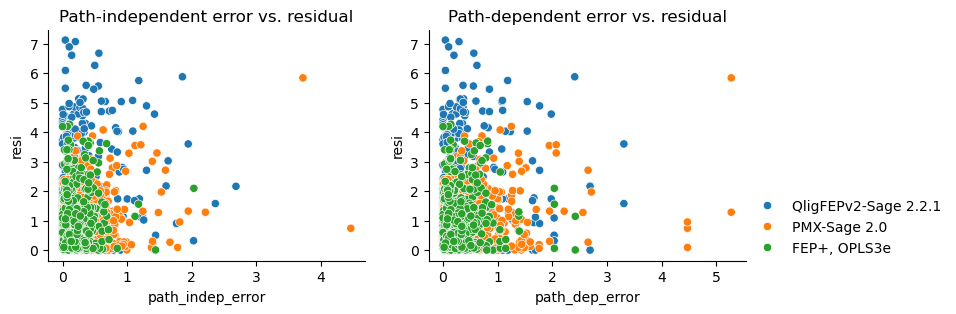

In [207]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

sns.scatterplot(
    data=all_dg_data.assign(resi=lambda x: (x["dg_value"] - x["sfc_dG"]).abs()),
    x="path_indep_error",
    y="resi",
    hue="value",
    ax=axs[0],
)

sns.scatterplot(
    data=all_dg_data.assign(resi=lambda x: (x["dg_value"] - x["sfc_dG"]).abs()),
    x="path_dep_error",
    y="resi",
    hue="value",
    ax=axs[1],
)
axs[0].set_title("Path-independent error vs. residual")
axs[0].legend_.remove()
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[1].set_title("Path-dependent error vs. residual")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].legend(bbox_to_anchor=(1.005, 0), loc="lower left", borderaxespad=0, frameon=False)

## Get metrics for $\Delta G$ values

In [208]:
qligfep_dG_metrics_df = get_metrics_df(
    qligfep_dG_dfs,
    ["KTAU", "RMSE", "MUE"],
    qligfep_result_df.target.unique().tolist(),
    pred_col="sfc_dG",
    exp_col="dg_value",
)

hahn_dG_metrics_df = get_metrics_df(
    dHahn_dG_dfs.query("value == 'DDG_OpenFF-2.0'").dropna(),
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="sfc_dG",
    exp_col="DG_Exp.",
)

opls3e_dG_metrics_df = get_metrics_df(
    dHahn_dG_dfs.query("value == 'DDG_OPLS3e'").dropna(),
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="sfc_dG",
    exp_col="DG_Exp.",
)

# print(qligfep_dG_metrics_df.to_markdown())

In [209]:
all_results = pd.concat(
    [
        qligfep_dG_metrics_df.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        hahn_dG_metrics_df.assign(ForceField="PMX-Sage 2.0", order=2),
        opls3e_dG_metrics_df.assign(ForceField="FEP+, OPLS3e", order=3),
    ],
    ignore_index=False,
)

details_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_1157370/1988591636.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1157370/1988591636.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


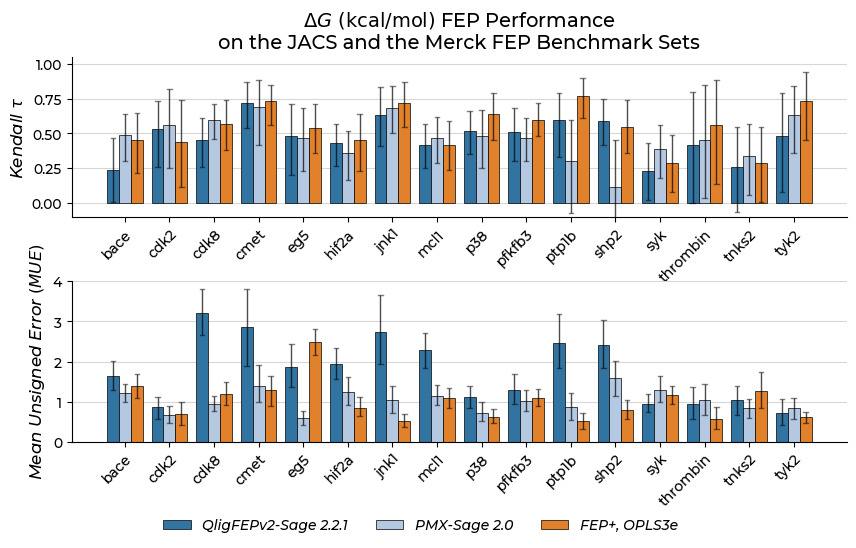

In [216]:
from typing import Literal


def plot_metrics_from_processed_FEP_df(
    df: pd.DataFrame,
    palette: str = "tab20",
    metrics=["KTAU", "MUE"],
    energy_type: Literal["dG", "ddG"] = "dG",
) -> tuple[plt.Figure, list[plt.Axes]]:
    fig, axs = plt.subplots(nrows=2, figsize=(10, 5))

    toplot_data = (
        df.reset_index(names=["target"])
        .assign(target_data=lambda x: x["target"] + " " + x["ForceField"])
        .sort_values(["target", "order"])
    )

    for ax, metric in zip(axs.flatten(), metrics):

        barplot = sns.barplot(
            toplot_data,
            hue="ForceField",
            x="target",
            y=f"{metric}_mean",
            ax=ax,
            palette=palette,
            edgecolor="black",
            linewidth=0.5,
        )

        # we use the error data because it has the correct order plotted by seaborn
        # 1st: plot all the values found in the `hue` column [0]
        # 2nd: plot all the values found in the `hue` column [1]
        # ...
        # We use order here because it represents the order where the `hue` values are found

        error_data = toplot_data.sort_values(["order", "target"])

        # idk why but barplot.patches contains all patches + 3 that are all equal to 0??
        # That's why we slice it
        data_patches = [p for p in barplot.patches if p.get_height() != 0 or p.get_width() != 0]

        # print(f"======== METRIC {metric} ========")
        for idx, bar in enumerate(data_patches):
            data_row = error_data.iloc[idx]

            if not np.isclose(bar.get_height(), data_row[f"{metric}_mean"]):
                print(f"Patch #{idx} height mismatch:")
                print(f"  - Bar Height (from plot):   {bar.get_height():.4f}")
                print(f"  - Data Value (from DF):     {data_row[f'{metric}_mean']:.4f}")
                print(f"  - Target {data_row['target']}; FF {data_row['ForceField']}")

            try:
                x_bar = bar.get_x() + bar.get_width() / 2
                # print(f"Processing Patch #{idx}:")
                # print(f"  - Bar Height (from plot):   {bar.get_height():.4f}")
                # print(f"  - Data Value (from DF):     {data_row[f'{metric}_mean']:.4f}")
                # print(f"  - Target {data_row['target']}; FF {data_row['ForceField']}")
            except IndexError:
                break

            y_start = data_row[f"{metric}_sub"]
            y_end = data_row[f"{metric}_sup"]
            # print(f"  - Lower Bound: {y_start:.4f}, Upper Bound: {y_end:.4f}")
            ax.vlines(x=x_bar, ymin=y_start, ymax=y_end, color="black", linewidth=1, alpha=0.7)
            cap_width = (
                0.1  # You can even make the cap width proportional to the bar width: bar.get_width() * 0.4
            )
            ax.plot(
                [x_bar - cap_width / 2, x_bar + cap_width / 2],
                [y_start, y_start],
                color="black",
                linewidth=1,
                alpha=0.5,
            )
            ax.plot(
                [x_bar - cap_width / 2, x_bar + cap_width / 2],
                [y_end, y_end],
                color="black",
                linewidth=1,
                alpha=0.5,
            )

        if metric == metrics[0]:
            if energy_type == "dG":
                ax.set_title(
                    r"$\Delta G\ (\mathrm{kcal/mol})$ FEP Performance"
                    "\non the JACS and the Merck FEP Benchmark Sets"
                )
            elif energy_type == "ddG":
                ax.set_title(
                    r"$\Delta\Delta G\ (\mathrm{kcal/mol})$ FEP Performance"
                    "\non the JACS and the Merck FEP Benchmark Sets"
                )

            # ax.set_title(
            #     "Analysis of Calculated $\Delta\Delta G (kcal/mol)$ Metrics for the JACS\nand the Merck FEP Benchmark Sets",
            # )
            # ax.legend(bbox_to_anchor=(1.02, -0.45), loc="lower left", borderaxespad=0, frameon=False)
            ax.set_ylabel(r"Kendall $\tau$")
            ax.legend().set_visible(False)
            ax.set_ylim(-0.1, 1.05)
        elif metric == "MUE":
            # ax.legend().set_visible(False)
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(0.45, -0.40),
                frameon=False,
                shadow=True,
                ncol=5,
            )
            ax.set_ylabel("Mean Unsigned Error $(MUE)$")
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            ha="right",
            rotation_mode="anchor",
            fontsize=10,
            family="monospace",
        )
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel("")
        ax.grid(axis="y", alpha=0.5)
        ax.set_axisbelow(True)
    # fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    return fig, axs


fig, axs = plot_metrics_from_processed_FEP_df(details_df)
for idx, ax in enumerate(axs.flatten()):
    set_font_properties(ax)

fig.savefig("figures/dG_FEP_stacked-metrics.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/dG_FEP_stacked-metrics.png", bbox_inches="tight", dpi=300, facecolor="white")

## Residual analysis $\Delta\Delta G_{calculated} - \Delta\Delta G_{experimental}$

In [84]:
residuals_toplot = (
    pd.concat(
        [
            qligfep_result_df[["target", "fep_name", "residual"]].assign(ForceField="QligFEPv2-Sage 2.2.1"),
            hahn_results[["target", "edge", "OpenFF20_residual"]]
            .assign(
                fep_name=lambda x: x["edge"].str.replace("edge_", "FEP_"),
                ForceField="Hahn et al. 2023 OpenFF 2.0",
            )
            .drop(columns=["edge"])
            .rename(columns={"OpenFF20_residual": "residual"}),
            hahn_results[["target", "edge", "OPLS3e_residual"]]
            .assign(fep_name=lambda x: x["edge"].str.replace("edge_", "FEP_"), ForceField="OPLS3e")
            .drop(columns=["edge"])
            .rename(columns={"OPLS3e_residual": "residual"}),
        ]
    )
    .query("target.isin(@targets)")
    .reset_index()
)

/tmp/ipykernel_1157370/189726291.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


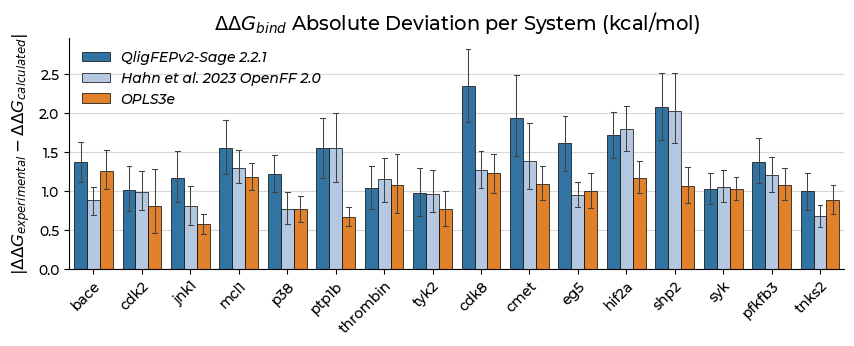

In [87]:
import matplotlib.font_manager as fm

# fontfile = str(Path().absolute() / "CascadiaMono-Italic.ttf")
# font_list = fm.get_font(fontfile)
# cascadia_font = fm.FontProperties(fname=fontfile)
fig, ax = plt.subplots(figsize=(10, 3))

palette = "tab20"

barplot = sns.barplot(
    residuals_toplot.assign(residual=lambda x: x["residual"].abs()),
    hue="ForceField",
    x="target",
    y="residual",
    ax=ax,
    palette=palette,
    edgecolor="black",
    linewidth=0.5,
    capsize=0.3,
    err_kws={"linewidth": 0.75},
    # alpha=0.5,
)

ax.legend(frameon=False)
sns.despine(ax=ax, top=True, right=True)
ax.set_axisbelow(True)
ax.grid(axis="y", alpha=0.5)
ax.set_ylabel(r"$|\Delta\Delta G_{experimental} - \Delta\Delta G_{calculated}|$")
# ax.set_ylabel(r"$\mathrm{Abs.} \Delta\Delta G\ \mathrm{(kcal/mol)}$")
ax.set_xlabel("")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=10,
    family="monospace",
)
ax.set_title(
    r"$\Delta\Delta G_{bind}$ Absolute Deviation per System (kcal/mol)",
)

set_font_properties(ax)

fig.savefig("figures/barplot_ddG_deviation.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/barplot_ddG_deviation.png", bbox_inches="tight", dpi=300, facecolor="white")

plt.show()

In [231]:
residuals_toplot.groupby("ForceField").value_counts(["target"])

ForceField                   target  
Hahn et al. 2023 OpenFF 2.0  syk         101
                             hif2a        92
                             mcl1         71
                             pfkfb3       66
                             eg5          65
                             tnks2        60
                             bace         58
                             cmet         57
                             p38          56
                             shp2         56
                             cdk8         54
                             ptp1b        49
                             jnk1         31
                             cdk2         25
                             tyk2         24
                             thrombin     16
OPLS3e                       syk         101
                             hif2a        92
                             mcl1         71
                             pfkfb3       66
                             eg5          65
                 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ptp1b_Hahn et al. 2023 OpenFF 2.0 vs. ptp1b_OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:8.231e-04 U_stat=1.644e+03
cdk8_QligFEPv2-Sage 2.2.1 vs. cdk8_Hahn et al. 2023 OpenFF 2.0: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:5.500e-04 U_stat=2.024e+03
shp2_Hahn et al. 2023 OpenFF 2.0 vs. shp2_OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:5.652e-04 U_stat=2.128e+03
ptp1b_QligFEPv2-Sage 2.2.1 vs. ptp1b_OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:5.717e-05 U_stat=1.217e+03
cdk8_QligFEPv2-Sage 2.2.1 vs. cdk8_OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:3.407e-04 U_stat=2.046e+03
eg5_QligFEPv2-Sage 2.2.1 vs. eg5_OPLS3e: Mann-Whi

/tmp/ipykernel_1157370/1355681617.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


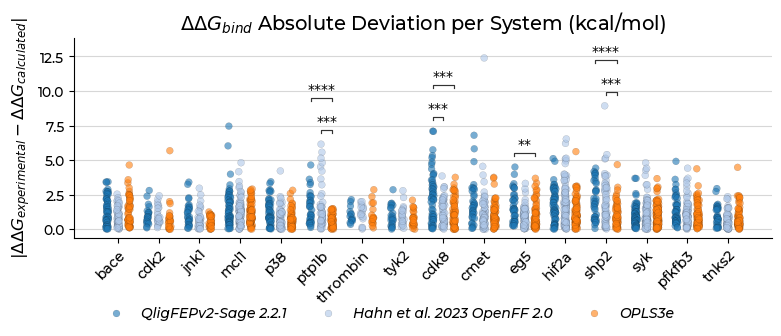

In [237]:
from statannotations.Annotator import Annotator


def get_significance_symbol(pvalue):
    """
      Converts a p-value to a significance symbol.

      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
    """
    if pvalue > 0.05:
        return "ns"
    elif pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    else:
        return ""


fig, ax = plt.subplots(figsize=(9, 2.6))

absolute = True
palette = "tab20"

figure_kwargs = {
    "hue": "ForceField",
    "x": "target",
    "y": "residual",
    "ax": ax,
    "dodge": True,
}
data = (
    residuals_toplot.assign(residual=lambda x: x["residual"].abs()) if absolute else residuals_toplot
).copy()

stripplot = sns.stripplot(
    data,
    **{
        "palette": palette,
        "size": 5,
        "edgecolor": "black",
        "linewidth": 0.1,
        "alpha": 0.6,
    },
    **figure_kwargs,
)

configuration = {
    "test": "Mann-Whitney-gt",
    "comparisons_correction": "holm",
    "text_format": "star",
    "hide_non_significant": True,
    "line_width": 0.85,
    "line_height": 0.015,
}


# Prepare the pairs for the statistical test
forcefields = data.ForceField.unique().tolist()
ff_combinations = list(combinations(forcefields, 2))
sig_test_pairs = []
for target in targets:
    for combi in ff_combinations:
        sig_test_pairs.append(((target, combi[0]), (target, combi[1])))
# Plot the statistical test results
annotator = Annotator(data=data, pairs=sig_test_pairs, plot="stripplot", **figure_kwargs)
_, annotations = annotator.configure(**configuration).apply_and_annotate()

stats_results = []

count_df = residuals_toplot.groupby("target").value_counts(["ForceField"])
for res in annotations:
    stats_results.append(
        {
            "group1": f"{' '. join(res.data.group1)}, ($N={count_df[res.data.group1]}$)",
            "group2": f"{' '.join(res.data.group2)}, ($N={count_df[res.data.group2]}$)",
            "pvalue": res.data.pvalue,
            "symbol": get_significance_symbol(res.data.pvalue),
        }
    )
stats_df = pd.DataFrame(stats_results)


# ['bonferroni', 'bonf', 'Bonferroni', 'holm-bonferroni', 'HB', 'Holm-Bonferroni', 'holm', 'benjamini-hochberg', 'BH', 'fdr_bh', 'Benjamini-Hochberg', 'fdr_by', 'Benjamini-Yekutieli', 'BY', None]

# Pretyfy the plot :)
sns.despine(ax=ax, top=True, right=True)
ax.set_axisbelow(True)
ax.grid(axis="y", alpha=0.5)
ax.set_ylabel(r"$|\Delta\Delta G_{experimental} - \Delta\Delta G_{calculated}|$")
ax.set_xlabel("")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=10, family="monospace"
)
# ax.legend(frameon=True, framealpha=1)
# ax.legend(bbox_to_anchor=(1.005, 0), loc="lower left", borderaxespad=0, frameon=False)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, -0.28),
    frameon=False,
    shadow=True,
    ncol=3,
)
ax.set_title(
    r"$\Delta\Delta G_{bind}$ Absolute Deviation per System (kcal/mol)",
)
set_font_properties(ax)

fig.savefig("figures/stripplot-with-stats_ddG_deviation.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/stripplot-with-stats_ddG_deviation.png", bbox_inches="tight", dpi=300, facecolor="white")

In [238]:
print(stats_df.to_markdown())

|    | group1                                         | group2                                         |      pvalue | symbol   |
|---:|:-----------------------------------------------|:-----------------------------------------------|------------:|:---------|
|  0 | cdk2 QligFEPv2-Sage 2.2.1, ($N=22$)            | cdk2 Hahn et al. 2023 OpenFF 2.0, ($N=25$)     | 0.428097    | ns       |
|  1 | cdk2 Hahn et al. 2023 OpenFF 2.0, ($N=25$)     | cdk2 OPLS3e, ($N=25$)                          | 0.0239029   | *        |
|  2 | jnk1 QligFEPv2-Sage 2.2.1, ($N=27$)            | jnk1 Hahn et al. 2023 OpenFF 2.0, ($N=31$)     | 0.0317966   | *        |
|  3 | jnk1 Hahn et al. 2023 OpenFF 2.0, ($N=31$)     | jnk1 OPLS3e, ($N=31$)                          | 0.306138    | ns       |
|  4 | mcl1 QligFEPv2-Sage 2.2.1, ($N=60$)            | mcl1 Hahn et al. 2023 OpenFF 2.0, ($N=71$)     | 0.194468    | ns       |
|  5 | mcl1 Hahn et al. 2023 OpenFF 2.0, ($N=71$)     | mcl1 OPLS3e, ($N=71$)             

In [28]:
# pd.set_option("display.float_format", lambda x: "%.3f" % x)
# data.groupby(["target", "ForceField"]).agg(
#     residual_median=("residual", "median"), counts=("residual", "count")
# ).reset_index()

# Plot metrics
Including bootstrapped confidence intervals for Kendall's tau, RMSE and MUE.

In [30]:
qligfep_metrics_df = get_metrics_df(
    qligfep_result_df,
    ["KTAU", "RMSE", "MUE"],
    qligfep_result_df.target.unique().tolist(),
    "Q_ddG_avg",
    "ddg_value",
)

hahn_metrics_df = get_metrics_df(
    hahn_results,
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="DDG_OpenFF-2.0",
    exp_col="DDG_Exp.",
)

opls3e_metrics_df = get_metrics_df(
    hahn_results.dropna(subset=["DDG_OPLS3e"]),
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="DDG_OPLS3e",
    exp_col="DDG_Exp.",
)

print(qligfep_metrics_df.to_markdown())

|          | KTAU                  | RMSE                 | MUE                  |   N |
|:---------|:----------------------|:---------------------|:---------------------|----:|
| bace     | $0.31_{0.13}^{0.48}$  | $1.69_{1.44}^{1.93}$ | $1.37_{1.13}^{1.63}$ |  55 |
| cdk2     | $0.3_{-0.05}^{0.59}$  | $1.21_{0.88}^{1.52}$ | $1.02_{0.78}^{1.31}$ |  22 |
| jnk1     | $0.35_{0.03}^{0.63}$  | $1.45_{1.05}^{1.82}$ | $1.17_{0.85}^{1.48}$ |  27 |
| mcl1     | $0.19_{0.02}^{0.36}$  | $2.04_{1.55}^{2.58}$ | $1.55_{1.24}^{1.9}$  |  60 |
| p38      | $0.58_{0.45}^{0.71}$  | $1.5_{1.25}^{1.77}$  | $1.22_{0.98}^{1.47}$ |  52 |
| ptp1b    | $0.39_{0.18}^{0.58}$  | $1.89_{1.46}^{2.31}$ | $1.55_{1.22}^{1.92}$ |  33 |
| thrombin | $0.43_{-0.05}^{0.83}$ | $1.17_{0.85}^{1.46}$ | $1.04_{0.77}^{1.35}$ |  14 |
| tyk2     | $0.32_{-0.07}^{0.61}$ | $1.21_{0.89}^{1.53}$ | $0.97_{0.68}^{1.26}$ |  22 |
| cdk8     | $0.24_{0.06}^{0.44}$  | $2.95_{2.39}^{3.48}$ | $2.35_{1.91}^{2.84}$ |  55 |
| cmet     | $0.44_{0

In [33]:
all_results = pd.concat(
    [
        qligfep_metrics_df.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        hahn_metrics_df.assign(ForceField="PMX-Sage 2.0", order=2),
        opls3e_metrics_df.assign(ForceField="FEP+, OPLS3e", order=3),
    ],
    ignore_index=False,
)

details_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_2729052/3956006735.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_2729052/3956006735.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


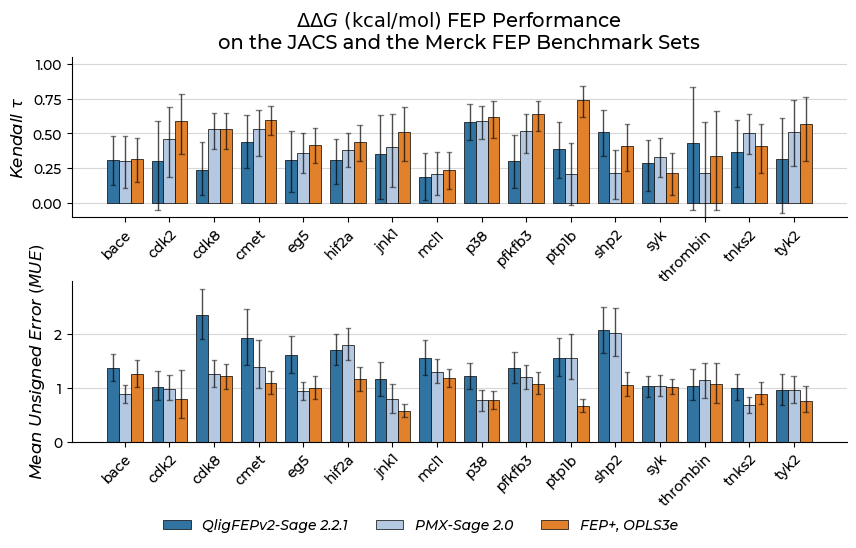

In [34]:
fig, axs = plot_metrics_from_processed_FEP_df(details_df, metrics=["KTAU", "MUE"], energy_type="ddG")
for ax in axs.flatten():
    set_font_properties(ax)
fig.savefig("figures/ddG_FEP_stacked-metrics.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/ddG_FEP_stacked-metrics.png", bbox_inches="tight", dpi=300, facecolor="white")

# Supplementary
Plotting the results including QmapFEP

In [36]:
openff2_qmapfep = pd.read_csv("supplementary/supplementary_openff2-0-0_QmapFEP.csv")
opls_qmapfep = pd.read_csv("supplementary/supplementary_opls2015_QmapFEP.csv")

qmapfep_openff2_metrics_df = get_metrics_df(
    openff2_qmapfep,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
)

qmapfep_opls_metrics_df = get_metrics_df(
    opls_qmapfep,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
)

In [43]:
all_results = pd.concat(
    [
        qligfep_metrics_df.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        qmapfep_openff2_metrics_df.assign(ForceField="QmapFEP-OpenFF 2.0", order=2),
        qmapfep_opls_metrics_df.assign(ForceField="QmapFEP-OPLS-AA 2015", order=3),
        hahn_metrics_df.assign(ForceField="PMX-Sage 2.0", order=4),
        opls3e_metrics_df.assign(ForceField="FEP+, OPLS3e", order=5),
    ],
    ignore_index=False,
)

details_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_2729052/3956006735.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_2729052/3956006735.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


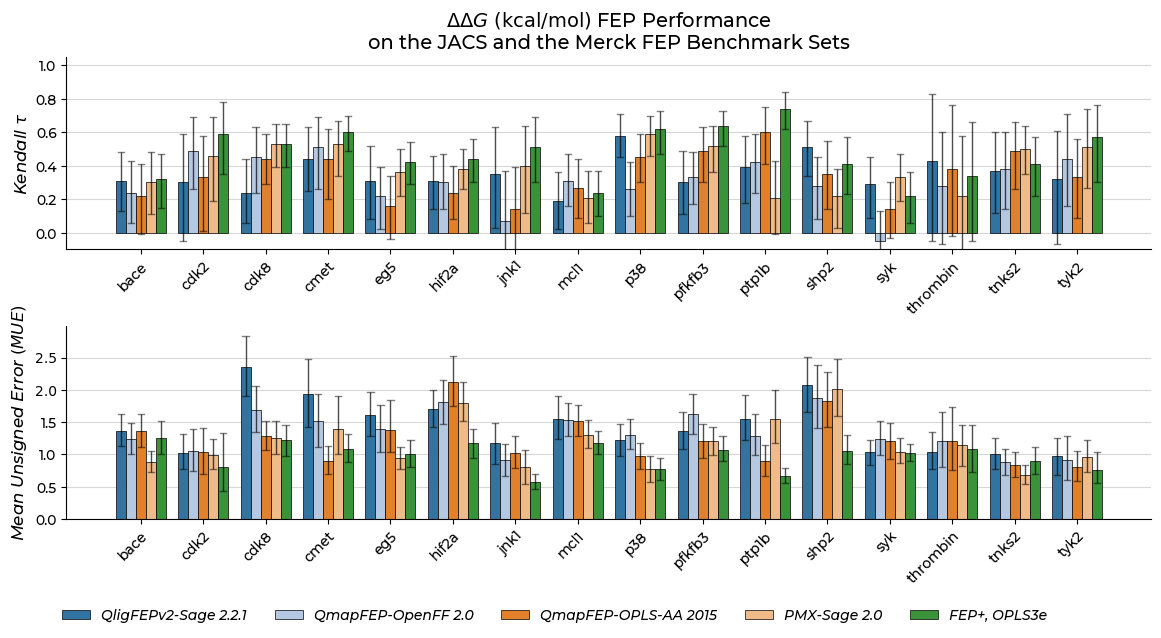

In [44]:
fig, axs = plot_metrics_from_processed_FEP_df(details_df, metrics=["KTAU", "MUE"], energy_type="ddG")
for ax in axs.flatten():
    set_font_properties(ax)
fig.set_size_inches(14, 6)